# **Rwanda/DRC flooding - preliminary analysis**

In [2]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *

---
## **Data pre-processing**

Datasets used:
- MSWEP: https://www.gloh2o.org/mswep/
- TAMSAT: http://www.tamsat.org.uk/
- CHIRPS: https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/
- CPC: https://psl.noaa.gov/data/gridded/data.cpc.globalprecip.html
- ERA5: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview

### **MSWEP**



In [9]:
# too much data to read & save in one go - save each year individually
for y in range(1979, 2021):
    
    ds = xr.open_mfdataset("/home/clair/Data/mswep_past/"+str(y)+"*.nc").sel(lon = slice(26,33), lat = slice(5,-6)).rename(precipitation = "precip")
    ds.to_netcdf("data/mswep_daily_26_33_-6_5_"+str(y)+".nc")

In [64]:
for y in range(2023, 2024):
    
    ds = xr.open_mfdataset("/home/clair/Data/mswep_nrt/"+str(y)+"*.nc").sel(lon = slice(26,33), lat = slice(5,-6)).rename(precipitation = "precip")
    ds.to_netcdf("data/mswep_daily_26_33_-6_5_"+str(y)+".nc")

### **CPC**

In [ ]:
cpc = xr.open_mfdataset("/home/clair/Data/cpc/precip.*.nc").sel(lon = slice(26,33), lat = slice(5,-6))
cpc.to_netcdf("data/cpc_daily_26_33_-6_5.nc")

### **CHIRPS**

In [3]:
chirps = xr.open_mfdataset("/home/clair/Data/chirps_05/*.nc").sel(longitude = slice(26,33), latitude = slice(-6,5))
# chirps_may = xr.open_dataset("data/chirps-may2023_26_33_-6_5.nc")   # preliminary data
# chirps = xr.concat([chirps, chirps_may], "time")
chirps.rename(latitude = "lat", longitude = "lon").to_netcdf("data/chirps_daily_26_33_-6_5.nc")

### **ERA5**

In [2]:
era5_2023 = xr.open_dataset("data/era5/era5_2023-hourly_26_33_-6_5.nc").tp.sel(time = slice("2023-05", None)).dropna("expver", "all").squeeze(drop = True)
era5_2023 = convert_units_to(era5_2023.resample(time = "D").sum(), "mm").rename(latitude = "lat", longitude = "lon")

era5 = xr.concat([xr.open_dataset("data/era5/era5_tp_daily_af_26-33E_-6-5N_su.nc").tp, era5_2023], "time").rename("precip")
era5.to_netcdf("data/era5_2023-daily_26_33_-6_5.nc")

# **Preliminary analysis**

---
## **Local geography**

- DRC: South Kivu province mentioned in trigger, along with Kahele & Nyamukubi
- Rwanda: separate trigger
- no trigger for Burundi/Uganda/Tanzania but may be part of same precipitation event?  
&nbsp;
- administrative shapefile data downloaded from https://data.humdata.org/
- elevation data from http://research.jisao.washington.edu/data_sets/elevation/
- river basin shapefiles from https://www.hydrosheds.org/products/hydrobasins

In [32]:
# load gridded elevation data
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(20,40), lat = slice(-15,10))

# load administrative shapefiles
drc = gpd.read_file("sf/drc-adm1").set_index("ADM1_FR")
sk = drc.loc[["Sud-Kivu"]]

ug = gpd.read_file("sf/uganda-adm1").set_index("ADM1_EN")
ugw = ug.loc[["Western"]]

rw = gpd.read_file("sf/rwanda-adm0")
bu = gpd.read_file("sf/burundi-adm0")

# get lat-lon coordinates of named locations; also define location of country labels
px = {k : get_latlon(k).values() for k in ["Kalehe", "Nyamukubi", "Goma", "Bushushu"]}
adm_labels = {"Uganda" : [30.8, 2], "DRC" : [23, -1], "Rwanda" : [31, -2], "Burundi" : [31,-3.4], "Tanzania" : [32.5, -6.5]}

# load shapefile for river basin & clip to required extent
hb05 = gpd.read_file("sf/hybas-lev05").clip([26,-6,33,5])

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [33]:
# create combined shapefile to plot area of (provisional) interest
sf = pd.concat([drc.loc[["Sud-Kivu", "Nord-Kivu"]], rw, bu, ugw]).clip([26,-6,33,1]).dissolve().explode()
sf = sf.loc[[a == sf.geometry.area.max() for a in sf.geometry.area]]
sf.geometry = sf.exterior.geometry.apply(lambda x: Polygon(x.coords))
sf.to_file("sf_provisional")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/tmp/ipykernel_192144/781264572.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf = pd.concat([drc.loc[["Sud-Kivu", "Nord-Kivu"]], rw, bu, ugw]).clip([26,-6,33,1]).dissolve().explode()
/tmp/ipykernel_192144/781264572.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sf = sf.loc[[a == sf.geometry.area.max() f

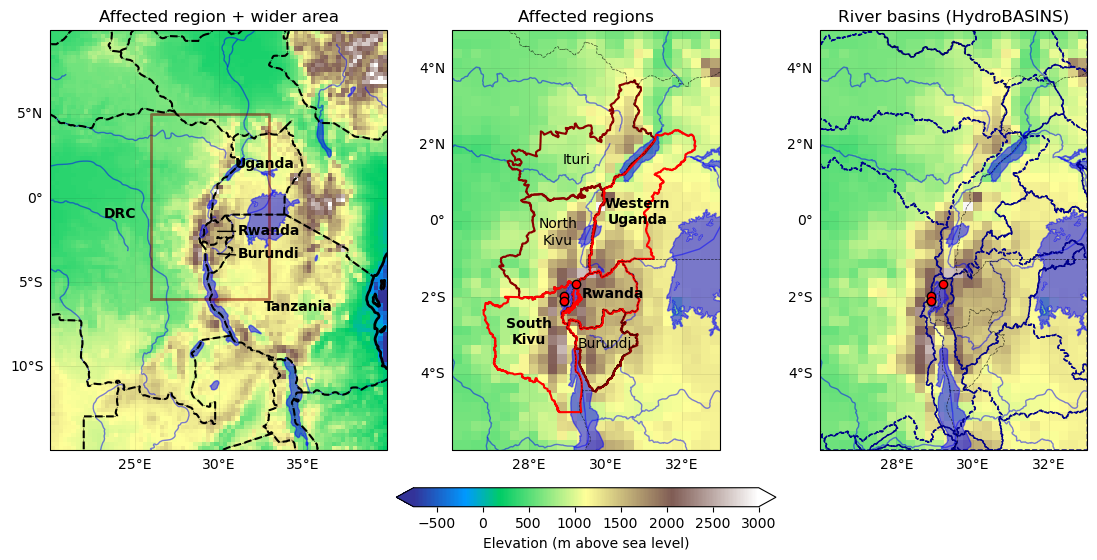

In [96]:
fig, axs = plt.subplots(ncols = 3, figsize = (14,7), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plt.subplots_adjust(wspace = 0.05)

elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
cbar = elev.plot(ax = ax, **elev_kwargs)

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left", "bottom"], alpha=0.1, xlocs = np.arange(20,40,5))
ax.set_title("Affected region + wider area")

ax.plot([26,26,33,33,26], [-6,5,5,-6,-6], color = "darkred", lw = 2, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, lw = 1.5, ls = "--", zorder = 99)

[ax.annotate(k, xy = v, fontweight = "bold", textcoords="offset points", xytext=(2,-2), ha='left') for k, v in adm_labels.items()]
ax.plot([rw.geometry.centroid.x[0], adm_labels["Rwanda"][0]], [rw.geometry.centroid.y[0], adm_labels["Rwanda"][1]], color = "k", lw = 1)
ax.plot([bu.geometry.centroid.x[0], adm_labels["Burundi"][0]], [bu.geometry.centroid.y[0], adm_labels["Burundi"][1]], color = "k", lw = 1)

# pd.concat([rw, bu, ugw, drc.loc[["Sud-Kivu", "Nord-Kivu", "Ituri"]]]).explode(index_parts = True).dissolve().boundary.plot(ax = ax)

# rectangle(26,33,-6,5, ax = ax, color = "k", alpha = 0.1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
elev.sel(lon = slice(26,33), lat = slice(-6,5)).plot(ax = ax, **elev_kwargs)
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
ax.set_title("Affected regions")

bu.boundary.plot(ax = ax, color = "darkred")
drc.loc[["Nord-Kivu", "Ituri"]].boundary.plot(ax = ax, color = "darkred")

sk.boundary.plot(ax = ax, color = "red")
rw.boundary.plot(ax = ax, color = "red")
ugw.boundary.plot(ax = ax, color = "red")

[ax.scatter(*xy, marker = "o", color = "red", edgecolor = "k", zorder = 999) for xy in px.values()]

ax.annotate("South\nKivu", xy = (sk.geometry.centroid.x-0.25, sk.geometry.centroid.y), ha = "center", fontweight = "bold")
ax.annotate("Rwanda", xy = (rw.geometry.centroid.x+0.25, rw.geometry.centroid.y), ha = "center", fontweight = "bold")
ax.annotate("Western\nUganda", xy = (ugw.geometry.centroid.x+0.1, ugw.geometry.centroid.y-0.5), ha = "center", fontweight = "bold")

ax.annotate("North\nKivu", xy = (drc.loc["Nord-Kivu"].geometry.centroid.x+0.05, drc.loc["Nord-Kivu"].geometry.centroid.y), ha = "center")
ax.annotate("Ituri", xy = (drc.loc["Ituri"].geometry.centroid.x-0.25, drc.loc["Ituri"].geometry.centroid.y-0.25), ha = "center")
ax.annotate("Burundi", xy = (bu.geometry.centroid.x+0.05, bu.geometry.centroid.y), ha = "center")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[2]
elev.sel(lon = slice(26,33), lat = slice(-6,5)).plot(ax = ax, **elev_kwargs)
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
ax.set_title("River basins (HydroBASINS)")

hb05.boundary.plot(ax = ax, color = "darkblue", lw = 1, ls = "--")
[ax.scatter(*xy, marker = "o", color = "red", edgecolor = "k", zorder = 999) for xy in px.values()]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:

    ax.coastlines(lw = 2)
    ax.add_feature(cartopy.feature.BORDERS, lw = 0.5, alpha = 0.7, ls = "--", zorder = 99)

    ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
    ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.5)
    
plt.colorbar(cbar, ax = axs, location = "bottom", extend = "both", shrink = 0.35, pad = 0.07, label = "Elevation (m above sea level)")

plt.savefig("fig/physical-geography.png")

---
## **Gridded datasets**

_Checked on June 1st: CHIRPS not yet updated beyond April 30th_

### **Maps of the event**

In [63]:
mswep = xr.open_mfdataset("/home/clair/Data/mswep_nrt/2023*.nc").sel(lon = slice(26,33), lat = slice(2,-5), time = "2023-05").precipitation.load()
cpc = xr.open_mfdataset("/home/clair/Data/cpc/precip.2023.nc").sel(lon = slice(26,33), lat = slice(2,-5), time = "2023-05").precip.load()
tamsat = xr.open_dataset("data/tamsat/01-tamsatDaily.v3.1_20230501-20230531_26.0_33.0_-6.0_5.0.nc").rfe_filled.load().sel(time = "2023-05", lat = slice(2,-5))
era5 = xr.open_dataset("data/era5_2023-daily_26_33_-6_5.nc").precip.sel(time = "2023-05", lat = slice(2,-5))
chirps = xr.open_dataset("data/chirps_daily_26_33_-6_5.nc").precip.sel(time = "2023-05", lat = slice(-5,2))

sf = gpd.read_file("sf_provisional")

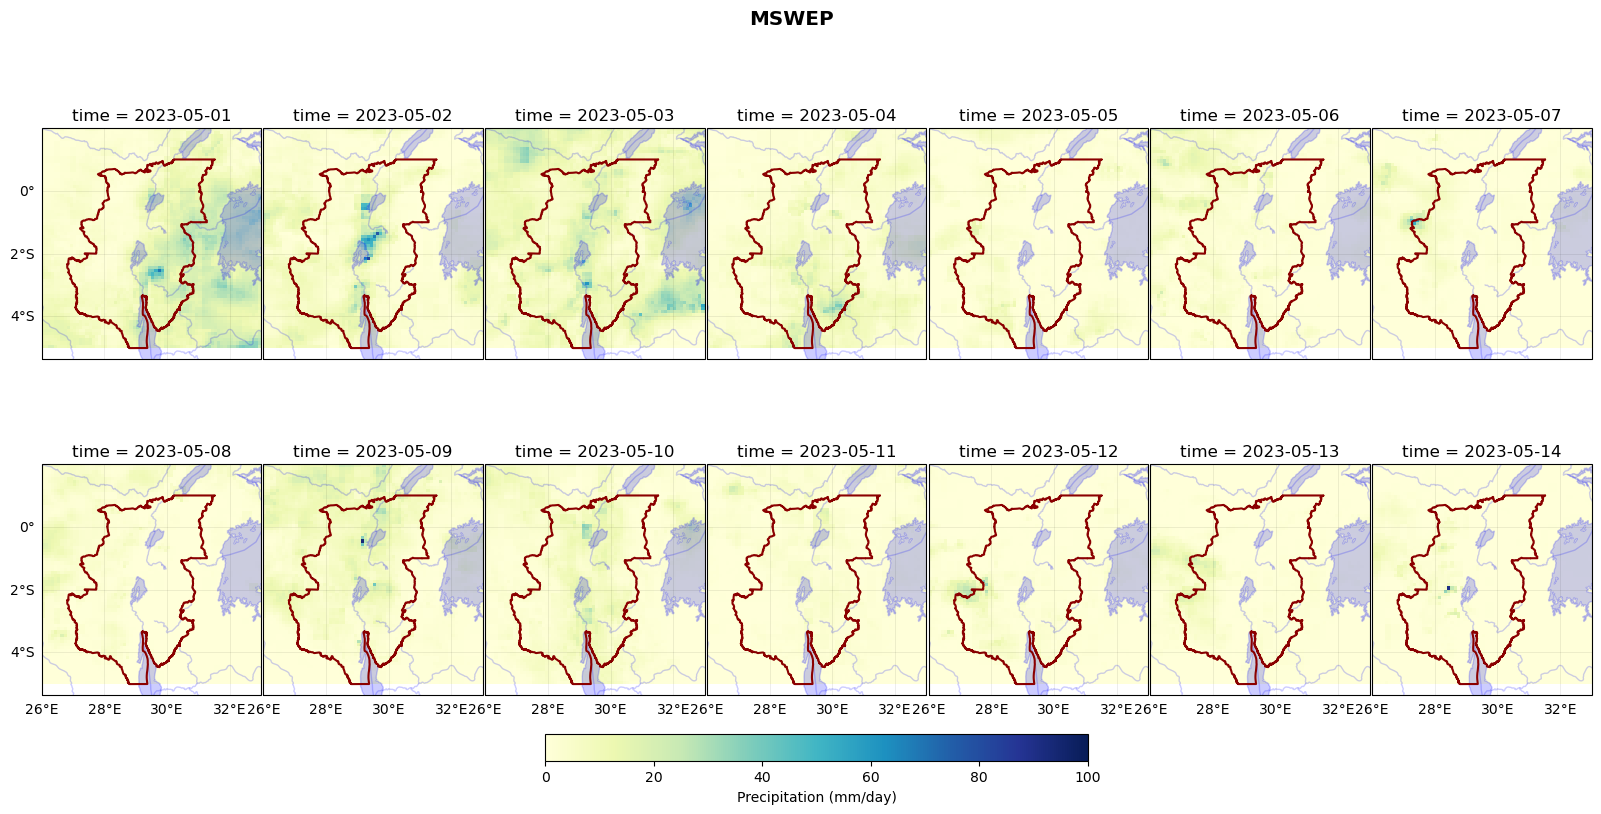

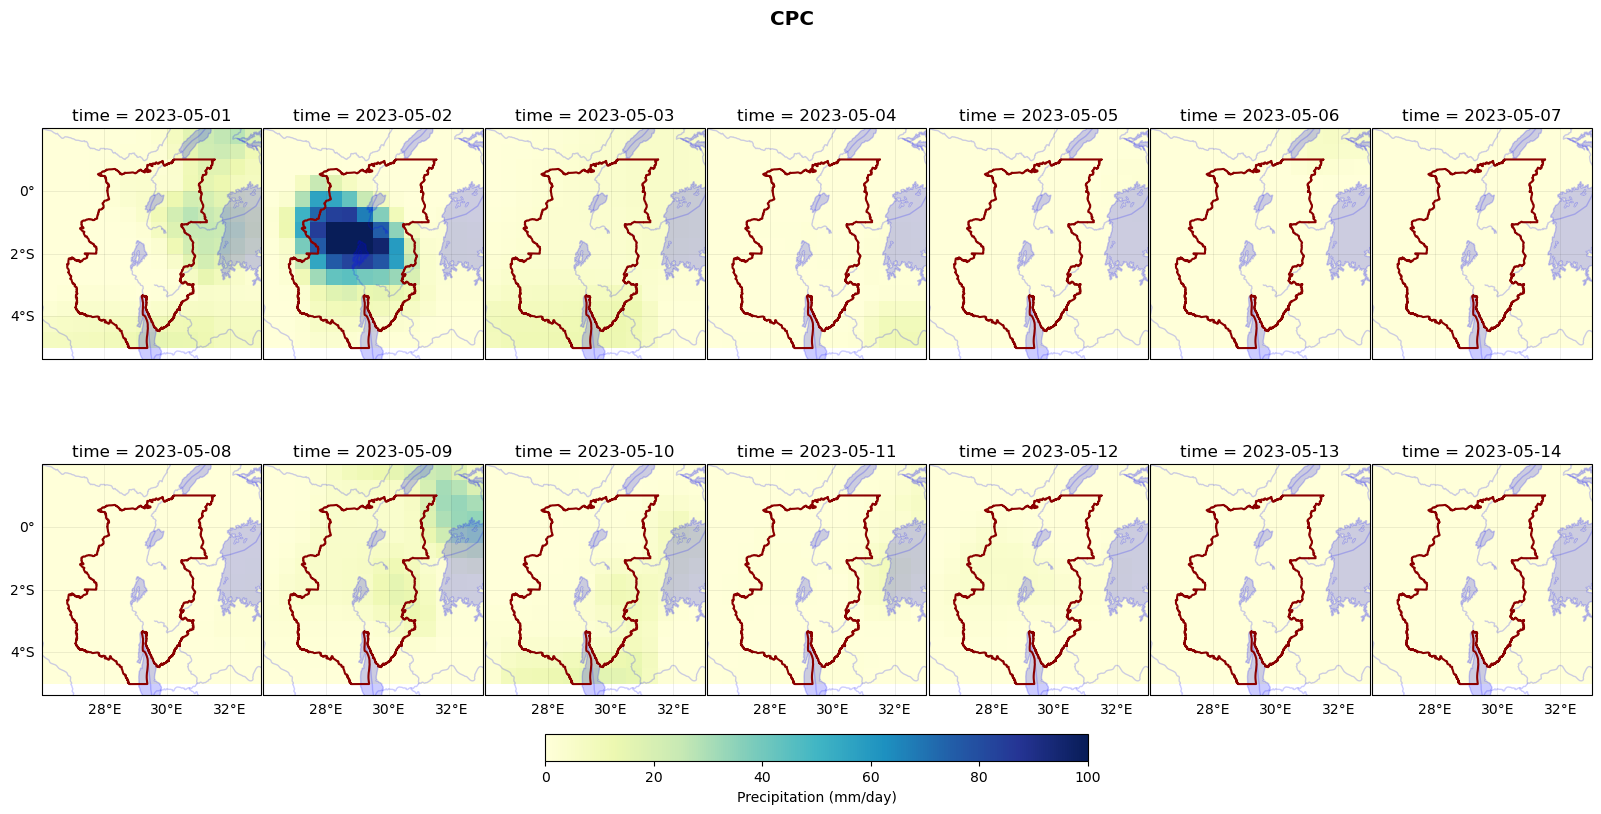

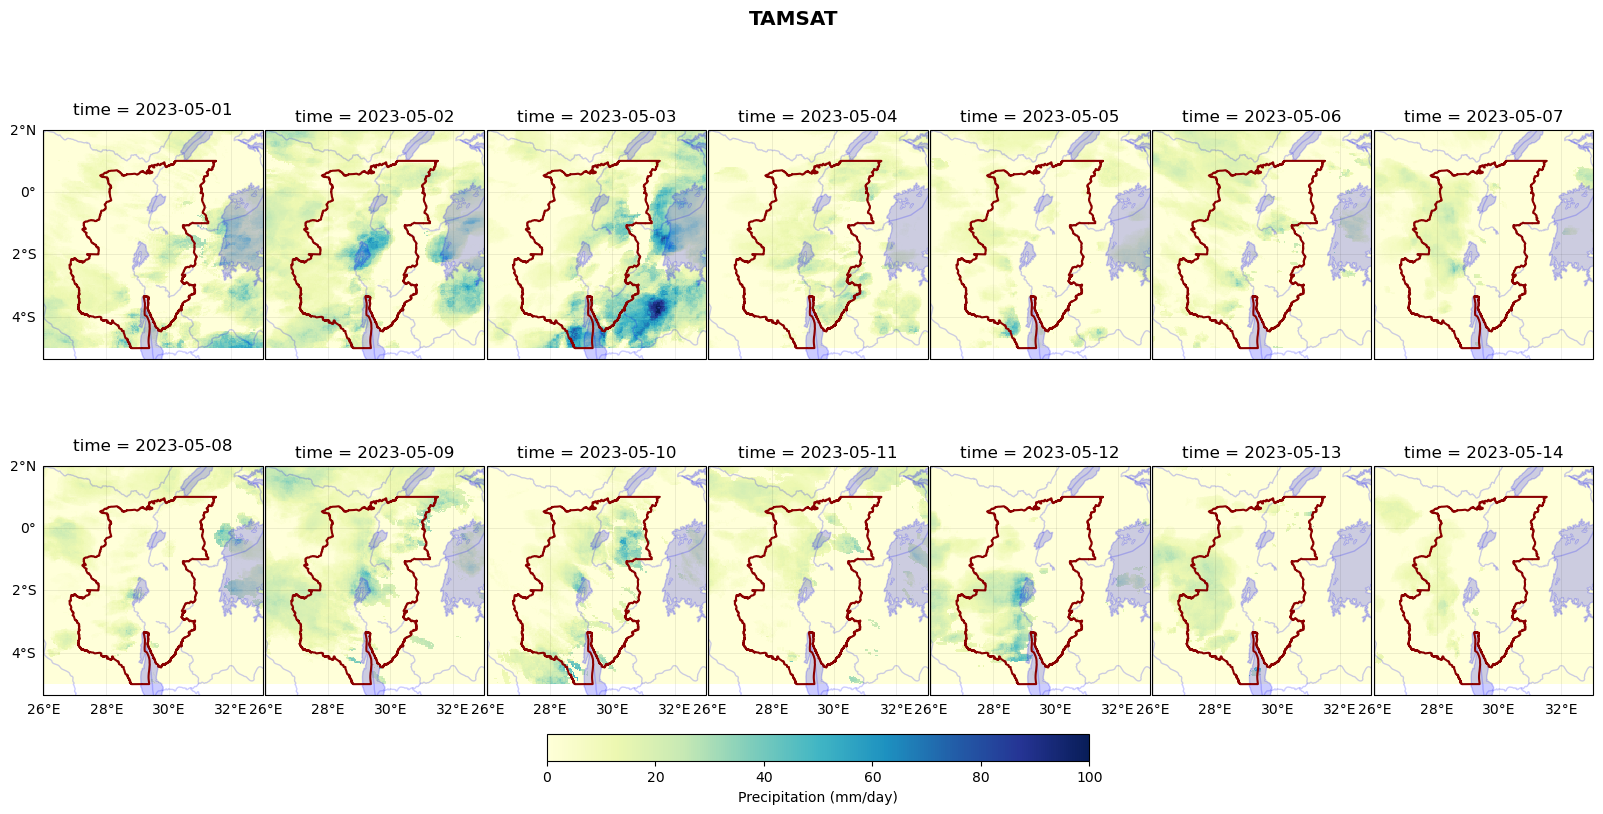

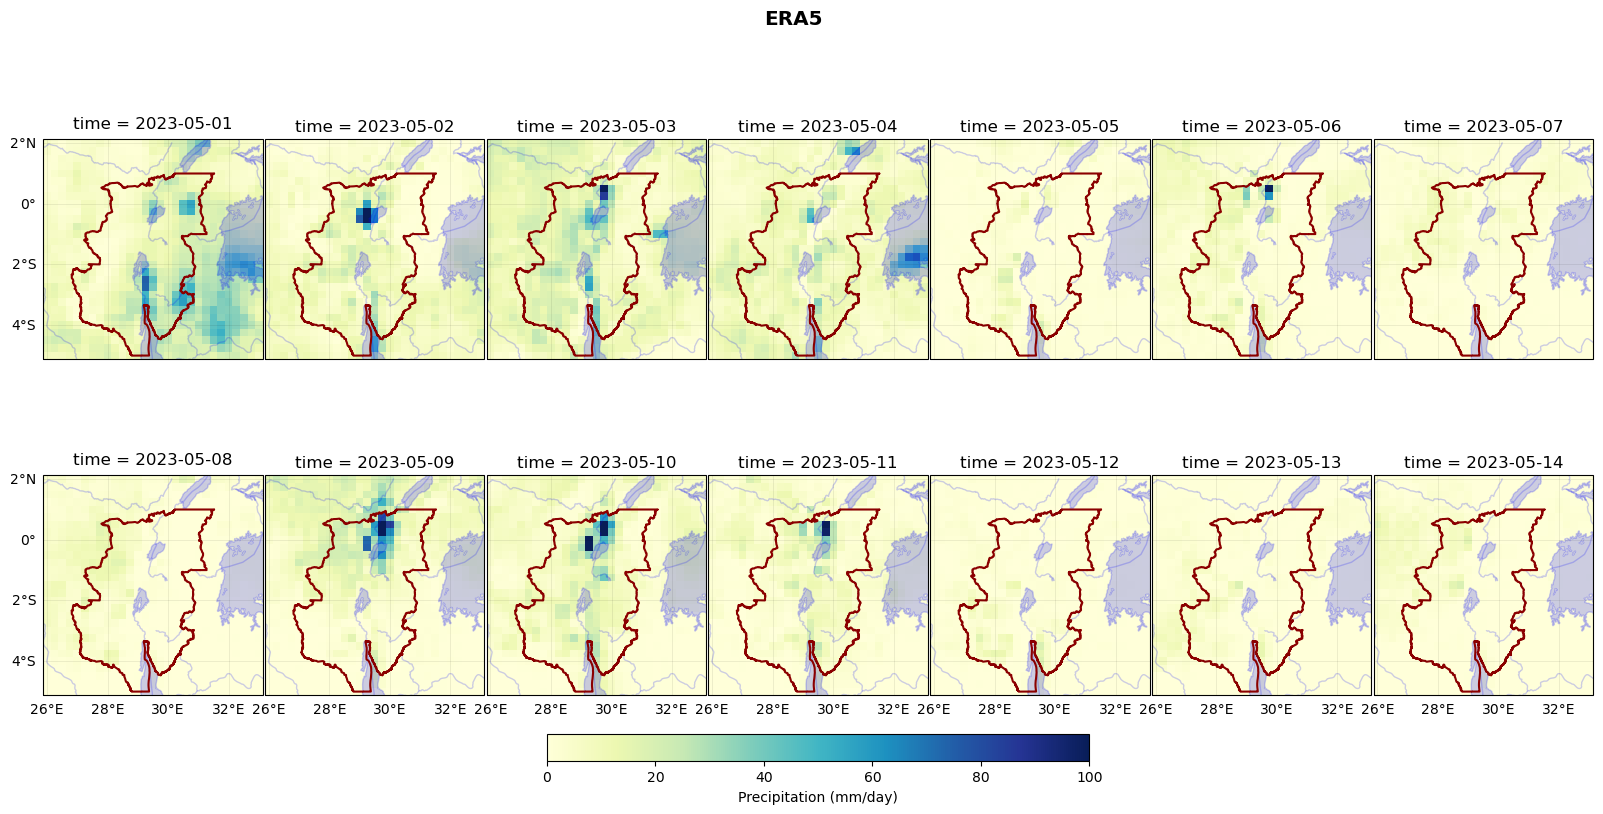

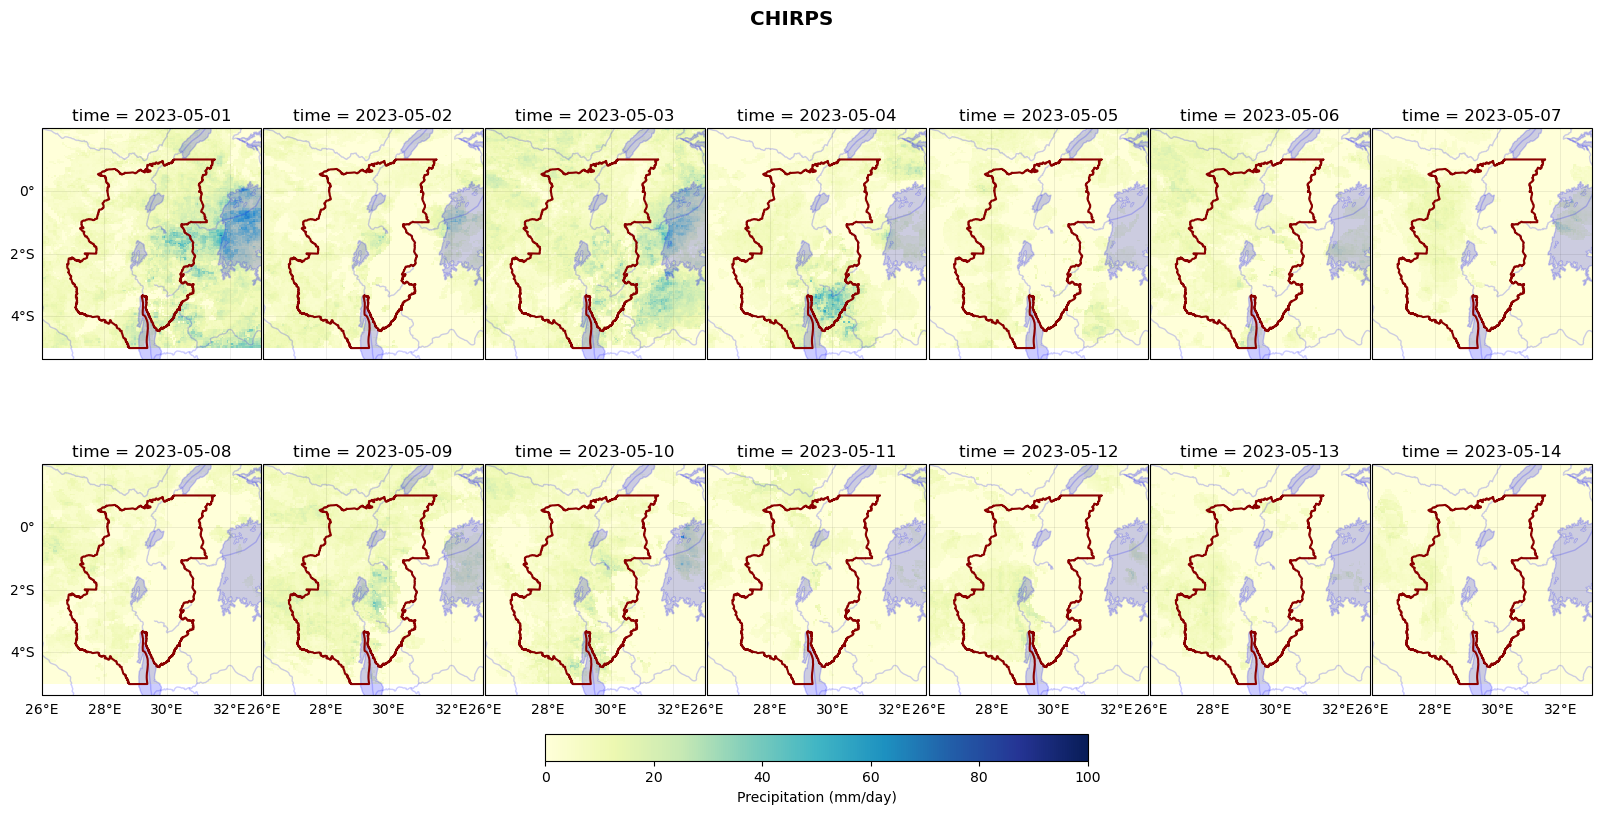

In [64]:
plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 100, "add_colorbar" : False}

for i in range(5):
    
    da_name = ["MSWEP", "CPC", "TAMSAT", "ERA5", "CHIRPS"][i]
    da = eval(da_name.lower())
    
    fig, axs = plt.subplots(ncols = 7, nrows = 2, figsize = (20,10), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
    plt.subplots_adjust(wspace = 0.01)
    plt.suptitle(da_name, fontsize='x-large', fontweight = "bold", y = 0.95)
    
    for j in range(14):
        ax = fig.axes[j]
        cbar = da.isel(time = j).plot(ax = ax, **plot_kwargs)
        sf.boundary.plot(ax = ax, color = "darkred")
        ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.2)
        ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.2)
        ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=[], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    
    for ax in axs[:,0]: ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    for ax in axs[-1,:]: ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))

    plt.colorbar(cbar, ax = axs, location = "bottom", shrink = 0.35, pad = 0.05, label = "Precipitation (mm/day)")
    
    plt.savefig("fig/may-precip_"+da_name.lower()+".png"); #plt.close()

### **Time series**

In [62]:
mswep = xr.open_mfdataset("data/mswep/mswep_daily_26_33_-6_5_*.nc").precip.load()
cpc = xr.open_dataset("data/cpc_daily_26_33_-6_5.nc").precip
tamsat = xr.open_mfdataset("data/tamsat/*.nc").rfe_filled.load().dropna("time", "all")
chirps = xr.open_dataset("data/chirps_daily_26_33_-6_5.nc").precip.dropna("time", "all")
era5 = xr.open_dataset("data/era5_2023-daily_26_33_-6_5.nc").precip

sf = gpd.read_file("sf_provisional")

#### **Time series over provisional region**

In [9]:
mswep_prov, cpc_prov, chirps_prov, tamsat_prov, era5_prov = [da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]) for da in [mswep, cpc, chirps, tamsat, era5]]

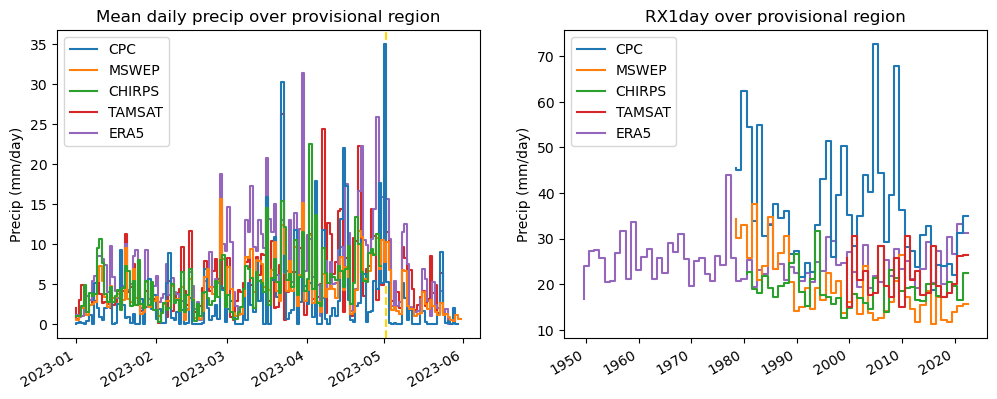

In [12]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cpc_prov.sel(time = "2023").plot(ax = axs[0], label = "CPC", drawstyle = "steps")
mswep_prov.sel(time = "2023").plot(ax = axs[0], label = "MSWEP", drawstyle = "steps")
chirps_prov.sel(time = "2023").plot(ax = axs[0], label = "CHIRPS", drawstyle = "steps")
tamsat_prov.sel(time = "2023").plot(ax = axs[0], label = "TAMSAT", drawstyle = "steps", zorder = -9)
era5_prov.sel(time = "2023").plot(ax = axs[0], label = "ERA5", drawstyle = "steps", zorder = -9)

axs[0].set_title("Mean daily precip over provisional region")
axs[0].axvline(np.datetime64("2023-05-02"), ls = "--", color = "gold", zorder = -99)
axs[0].legend()

# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cpc_prov.resample(time = "AS-JUL").max().plot(label = "CPC", drawstyle = "steps")
mswep_prov.resample(time = "AS-JUL").max().plot(label = "MSWEP", drawstyle = "steps")
chirps_prov.resample(time = "AS-JUL").max().plot(label = "CHIRPS", drawstyle = "steps")
tamsat_prov.resample(time = "AS-JUL").max().plot(label = "TAMSAT", drawstyle = "steps")
era5_prov.resample(time = "AS-JUL").max().plot(label = "ERA5", drawstyle = "steps", zorder = -9)

axs[1].legend()
axs[1].set_title("RX1day over provisional region")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("Precip (mm/day)")

plt.savefig("fig/provisional-region_timeseries.png")

#### **Time series over Lake Kivu only**

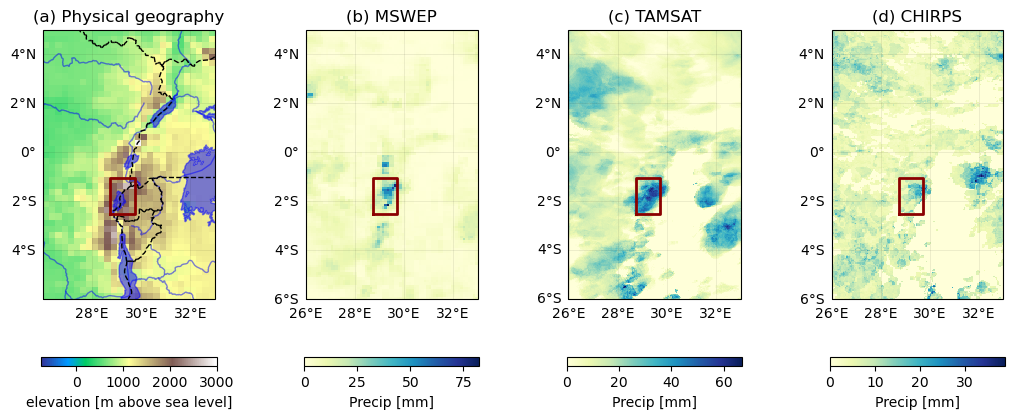

In [63]:
# small box centred on Lake Kivu
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(20,40), lat = slice(-15,10))
elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : True}
lk = get_latlon("Lake Kivu")

cbar_kwargs = {"location" : "bottom", "shrink" : 0.8}

fig, axs = plt.subplots(ncols = 4, figsize = (13,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
elev.sel(lon = slice(26,33), lat = slice(-6,5)).plot(ax = axs[0], **elev_kwargs, cbar_kwargs = cbar_kwargs)
axs[0].set_title("(a) Physical geography")
axs[0].add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.5)
axs[0].add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
axs[0].add_feature(cartopy.feature.BORDERS, color = "k", ls = "--")
    
mswep.sel(time = "2023-05-02").plot(ax = axs[1], cmap = "YlGnBu", vmin = 0, add_colorbar = True, cbar_kwargs = cbar_kwargs | {"label" : "Precip [mm]"})
axs[1].set_title("(b) MSWEP")

tamsat.sel(time = "2023-05-02").plot(ax = axs[2], cmap = "YlGnBu", vmin = 0, add_colorbar = True, cbar_kwargs = cbar_kwargs | {"label" : "Precip [mm]"})
axs[2].set_title("(c) TAMSAT")

chirps.sel(time = "2023-05-02").plot(ax = axs[3], cmap = "YlGnBu", vmin = 0, add_colorbar = True, cbar_kwargs = cbar_kwargs | {"label" : "Precip [mm]"})
axs[3].set_title("(d) CHIRPS")


x0 = -0.5; x1 = 0.5; y0 = -0.5; y1 = 1

for ax in axs:

    ax.plot([lk["lon"] + x_adj for x_adj in [x0,x0,x1,x1,x0]], [lk["lat"] + y_adj for y_adj in [y0,y1,y1,y0,y0]], color = "darkred", lw = 2)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    
plt.savefig("fig/lake-kivu_region.png")

In [64]:
mswep_lk = mswep.sel(lon = slice(lk["lon"]+x0, lk["lon"]+x1), lat = slice(lk["lat"]+y1, lk["lat"]+y0)).mean(["lat", "lon"])      # latitudes reversed
tamsat_lk = tamsat.sel(lon = slice(lk["lon"]+x0, lk["lon"]+x1), lat = slice(lk["lat"]+y1, lk["lat"]+y0)).mean(["lat", "lon"])    # latitudes reversed
chirps_lk = chirps.sel(lon = slice(lk["lon"]+x0, lk["lon"]+x1), lat = slice(lk["lat"]+y0, lk["lat"]+y1)).mean(["lat", "lon"])
era5_lk = era5.sel(lon = slice(lk["lon"]+x0, lk["lon"]+x1), lat = slice(lk["lat"]+y1, lk["lat"]+y0)).mean(["lat", "lon"])
cpc_lk = cpc.sel(lon = slice(lk["lon"]+x0, lk["lon"]+x1), lat = slice(lk["lat"]+y1, lk["lat"]+y0)).mean(["lat", "lon"])

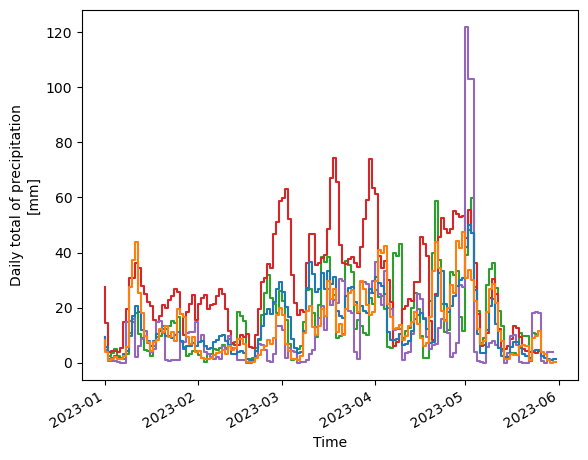

In [73]:
mswep_lk.rolling(time = 3).sum().sel(time = "2023").plot(label = "MSWEP", drawstyle = "steps")
chirps_lk.rolling(time = 3).sum().sel(time = "2023").plot(label = "CHIRPS", drawstyle = "steps")
tamsat_lk.rolling(time = 3).sum().sel(time = "2023").plot(label = "TAMSAT", drawstyle = "steps", zorder = -9)
era5_lk.rolling(time = 3).sum().sel(time = "2023").plot(label = "ERA5", drawstyle = "steps", zorder = -9)
cpc_lk.rolling(time = 3).sum().sel(time = "2023").plot(label = "CPC", drawstyle = "steps", zorder = -9)

# axs[0].set_title("Mean daily precip over Lake Kivu region")
# axs[0].axvline(np.datetime64("2023-05-02"), ls = "--", color = "gold", zorder = -99)
# axs[0].legend()

# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# mswep_lk.resample(time = "AS-JUL").max().plot(label = "MSWEP", drawstyle = "steps")
# chirps_lk.resample(time = "AS-JUL").max().plot(label = "CHIRPS", drawstyle = "steps")
# tamsat_lk.resample(time = "AS-JUL").max().plot(label = "TAMSAT", drawstyle = "steps")
# era5_lk.resample(time = "AS-JUL").max().plot(label = "ERA5", drawstyle = "steps")

# axs[1].legend()
# axs[1].set_title("RX1day over Lake Kivu region")


# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# for ax in axs:
#     ax.set_xlabel("")
#     ax.set_ylabel("Precip (mm/day)")

plt.savefig("fig/lake-kivu_3day-timeseries.png")

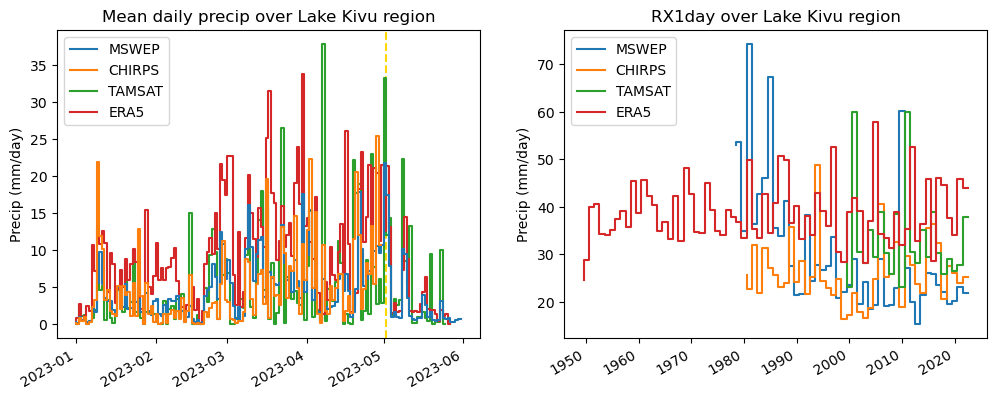

In [15]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

mswep_lk.sel(time = "2023").plot(ax = axs[0], label = "MSWEP", drawstyle = "steps")
chirps_lk.sel(time = "2023").plot(ax = axs[0], label = "CHIRPS", drawstyle = "steps")
tamsat_lk.sel(time = "2023").plot(ax = axs[0], label = "TAMSAT", drawstyle = "steps", zorder = -9)
era5_lk.sel(time = "2023").plot(ax = axs[0], label = "ERA5", drawstyle = "steps", zorder = -9)

axs[0].set_title("Mean daily precip over Lake Kivu region")
axs[0].axvline(np.datetime64("2023-05-02"), ls = "--", color = "gold", zorder = -99)
axs[0].legend()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

mswep_lk.resample(time = "AS-JUL").max().plot(label = "MSWEP", drawstyle = "steps")
chirps_lk.resample(time = "AS-JUL").max().plot(label = "CHIRPS", drawstyle = "steps")
tamsat_lk.resample(time = "AS-JUL").max().plot(label = "TAMSAT", drawstyle = "steps")
era5_lk.resample(time = "AS-JUL").max().plot(label = "ERA5", drawstyle = "steps")

axs[1].legend()
axs[1].set_title("RX1day over Lake Kivu region")


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("Precip (mm/day)")

plt.savefig("fig/lake-kivu_timeseries.png")

### **rxnday for different domains**

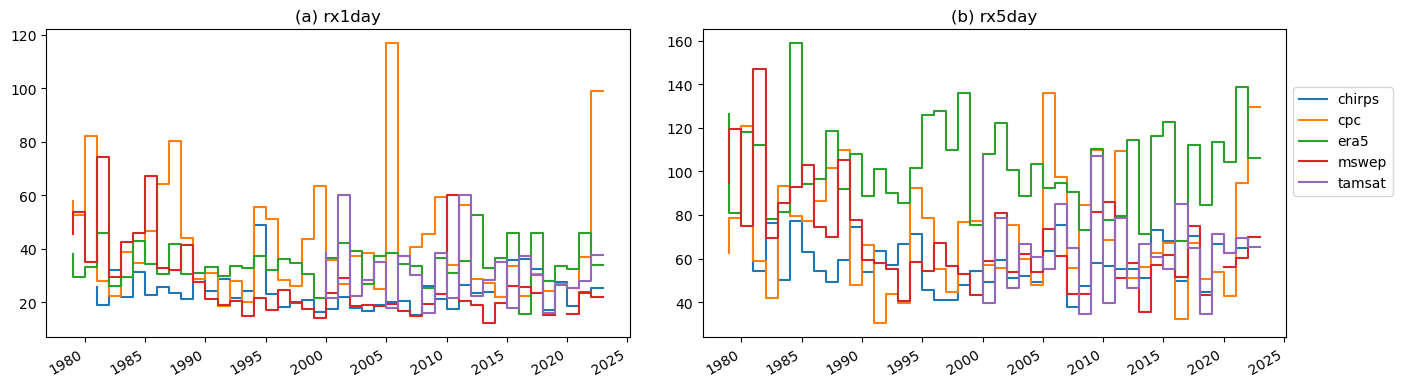

In [ ]:
fig, axs = plt.subplots(ncols = 2, figsize = (16,4))
plt.subplots_adjust(wspace = 0.125)

fl = sorted(glob.glob("daily/*_lake-kivu.nc"))

for i in range(2):
    n = [1,5][i]
    ax = axs[i]
    for fnm in fl:
        
        da = xr.open_dataset(fnm)
        da = da[list(da.data_vars)[0]]
        ds = re.sub("_.+", "", re.sub(".+/", "", fnm))
        
        rxnday = da.rolling(time = n).sum().sel(time = [m in [3,4,5] for m in da.time.dt.month]).resample(time = "AS-JAN").max().sel(time = slice("1979", None))
        rxnday.plot(ax = ax, drawstyle = "steps", label = ds)
        
    ax.set_title("("+["a","b"][i]+") rx"+str(n)+"day")
    ax.set_ylabel("")
    ax.set_xlabel("")
        
fig.legend([re.sub("_.+", "", re.sub(".+/", "", fnm)) for fnm in fl], bbox_to_anchor = (0.9,0.6), loc = "center left")
# fig.suptitle("Lake Kivu region (1 x 1.5 box)")
plt.savefig("fig/rxnday-mam_lake-kivu.png")

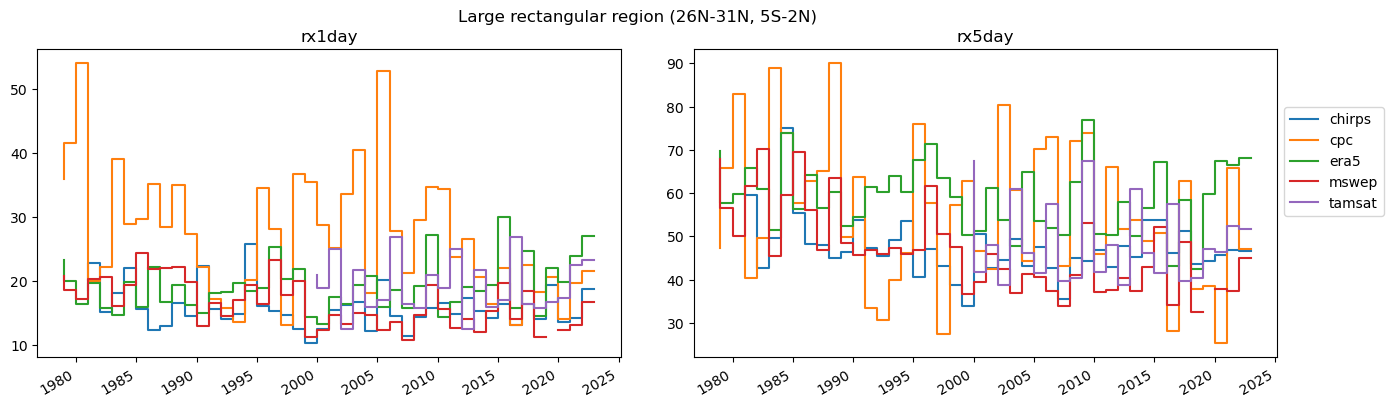

In [ ]:
fig, axs = plt.subplots(ncols = 2, figsize = (16,4))
plt.subplots_adjust(wspace = 0.125)

fl = sorted(glob.glob("daily/*_26_31_-5_2.nc"))

for i in range(2):
    n = [1,5][i]
    ax = axs[i]
    for fnm in fl:
        
        da = xr.open_dataset(fnm)
        da = da[list(da.data_vars)[0]]
        ds = re.sub("_.+", "", re.sub(".+/", "", fnm))
        
        rxnday = da.rolling(time = n).sum().sel(time = [m in [3,4,5] for m in da.time.dt.month]).resample(time = "AS-JAN").max().sel(time = slice("1979", None))
        rxnday.plot(ax = ax, drawstyle = "steps", label = ds)
        
    ax.set_title("rx"+str(n)+"day")
    ax.set_ylabel("")
    ax.set_xlabel("")
    
fig.legend([re.sub("_.+", "", re.sub(".+/", "", fnm)) for fnm in fl], bbox_to_anchor = (0.9,0.6), loc = "center left")
fig.suptitle("Large rectangular region (26N-31N, 5S-2N)")
plt.savefig("fig/rxnday-mam_26_31_-5_2.png")

In [ ]:
fig, axs = plt.subplots(ncols = 2, figsize = (16,4))

fl = sorted(glob.glob("daily/*_shapefile.nc"))

for i in range(2):
    n = [1,5][i]
    ax = axs[i]
    for fnm in fl:
        
        da = xr.open_dataset(fnm)
        da = da[list(da.data_vars)[0]]
        ds = re.sub("_.+", "", re.sub(".+/", "", fnm))
        
        rxnday = da.rolling(time = n).sum().sel(time = [m in [3,4,5] for m in da.time.dt.month]).resample(time = "AS-JAN").max().sel(time = slice("1979", None))
        rxnday.plot(ax = ax, drawstyle = "steps", label = ds)
        
    ax.set_title("rx"+str(n)+"day")
    ax.set_ylabel("")
    ax.set_xlabel("")
    
fig.legend([re.sub("_.+", "", re.sub(".+/", "", fnm)) for fnm in fl], bbox_to_anchor = (0.9,0.6), loc = "center left")
fig.suptitle("Provisional region from shapefile")
plt.savefig("fig/rxnday-mam_shapefile.png")

SyntaxError: invalid syntax (2603572289.py, line 14)

---
## **Station data**

### **Map of GCND station locations (not used)**

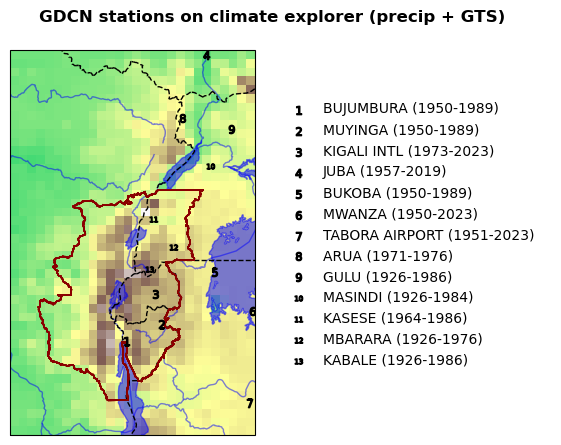

In [22]:
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(20,40), lat = slice(-15,10))
elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : False}
sf = gpd.read_file("sf_provisional")

fig, axs = plt.subplots(ncols = 2, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
ax = axs[0]
elev.sel(lon = slice(26,33), lat = slice(-6,5)).plot(ax = ax, **elev_kwargs)

ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.5)
ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--")

fl = sorted(glob.glob("data/pgdcngts*.nc"))
for i in range(len(fl)):
    
    fnm = fl[i]
    da = xr.open_dataset(fnm)
    
    lat = float(da.latitude.strip().split(" ")[0])
    lon = float(da.longitude.strip().split(" ")[0])
    stn = da.description + " ("+"-".join([str(d) for d in da.isel(time = [0,-1]).time.dt.year.values])+")"
    
    ax.scatter(lon, lat, marker = "$"+str(i+1)+"$", color = "k", label = stn, zorder = 99)
    sf.boundary.plot(ax = ax, color = "darkred", lw = 1)
    
axs[1].set_axis_off()
fig.legend(bbox_to_anchor = (0.5,0.8), loc = "upper left", edgecolor = "w")
plt.suptitle("GDCN stations on climate explorer (precip + GTS)", fontweight = "bold", y = 0.96)
plt.savefig("fig/gdcn-station-locations.png")

---
## **Synoptic conditions**

In [44]:
ds = xr.open_dataset("data/era5_drc-rwanda_mslp-uv-slp_earlyMay2023.nc").resample(time = "D").mean().sortby("latitude")
ds["msl"] = convert_units_to(ds.msl, "hPa")
ds["sp"] = convert_units_to(ds.sp, "hPa")

clim = convert_units_to(xr.open_dataset("data/era5_drc-rwanda_mslp_May-hist.nc").msl.mean(["time", "expver"]), "hPa")
ds["msl_anom"] = ds.msl - clim

sf = gpd.read_file("sf_provisional")


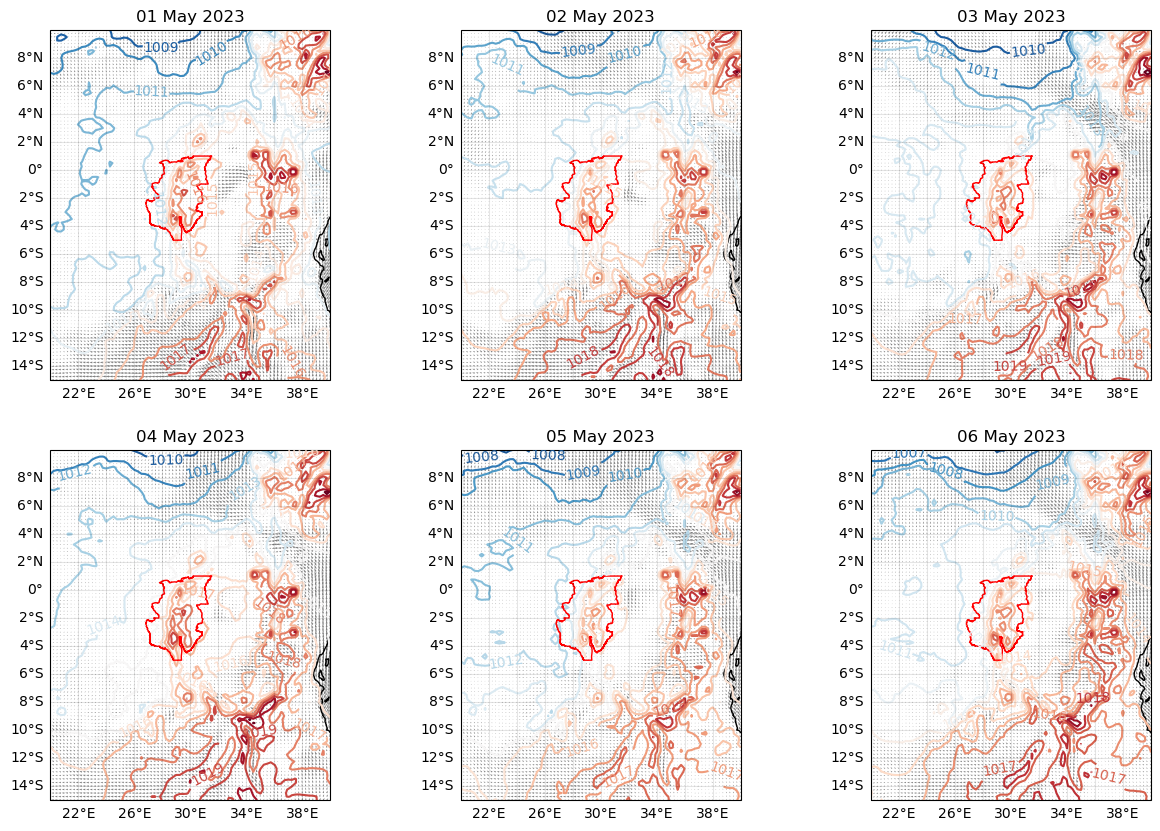

In [46]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (15,10), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

for i in range(6):
    
    ax = fig.axes[i]
    
    ds_i = ds.isel(time = i)
    
    cs = ax.contour(ds.longitude, ds.latitude, ds_i.msl, cmap = "RdBu_r", levels = np.arange(int(np.floor(ds_i.msl.min())), int(np.ceil(ds_i.msl.max())), 1))
    ax.clabel(cs)
    ax.quiver(ds.longitude, ds.latitude, ds_i.u10, ds_i.v10, alpha = 0.5)
    ax.set_title(ds_i.time.dt.strftime("%d %b %Y").values.tolist())
    
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "red", lw = 1)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(20,40,2), ylocs = range(-16,16,2))
    
# plt.savefig("fig/synoptic-conditions.png")

---
# **Analysis for scientific report**

After initial discussion on June 1st, was agreed that we would look at accumulated n-day precip for 1, 2, 5, 7 days over a region 26E-31E, 5S-2N, and also the smaller region suggested above.


## **Pre-processing of gridded data products**
Compute daily time series over each domain

In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *

In [ ]:
# mswep = xr.open_mfdataset("data/mswep/mswep_daily_26_33_-6_5_*.nc").precip.load()
# cpc = xr.open_dataset("data/cpc_daily_26_33_-6_5.nc").precip
# tamsat = xr.open_mfdataset("data/tamsat/*.nc").rfe_filled.load().dropna("time", "all")
chirps = xr.open_dataset("data/chirps_daily_26_33_-6_5.nc").precip.dropna("time", "all")
# era5 = xr.open_dataset("data/era5_2023-daily_26_33_-6_5.nc").precip

sf = gpd.read_file("sf_provisional")

In [4]:
lk = get_latlon("Lake Kivu")
x0 = -0.5; x1 = 0.5; y0 = -0.5; y1 = 1

lk_lon = slice(lk["lon"]+x0, lk["lon"]+x1)
lk_lat = slice(lk["lat"]+y0, lk["lat"]+y1)

In [6]:
## TIME SERIES FOR CLIMATE EXPLORER
for ds_nm in ["mswep", "cpc", "chirps", "tamsat", "era5"][2:3]:

    # load data, compute index
    da = eval(ds_nm)
    da = da.sortby(da.lat)
    
    sf_ts = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"])
    sf_ts.to_netcdf("daily/"+ds_nm+"_daily_shapefile.nc")
    
    large_ts = da.sel(lon = slice(26,31), lat = slice(-5,2)).mean(["lat", "lon"])
    large_ts.to_netcdf("daily/"+ds_nm+"_daily_26_31_-5_2.nc")
    
    small_ts = da.sel(lon = lk_lon, lat = lk_lat).mean(["lat", "lon"])
    small_ts.to_netcdf("daily/"+ds_nm+"_daily_lake-kivu.nc")

### **Time series for climate explorer**


#### **rx1day Lake Kivu**

In [7]:
## TIME SERIES FOR CLIMATE EXPLORER

ndays = 1
region = "lake-kivu"

for ds_nm in ["mswep", "cpc", "chirps", "tamsat", "era5"][2:3]:

    # load data, compute index
    ts = xr.open_dataset("daily/"+ds_nm+"_daily_"+region+".nc")
    ts = ts[list(ts.data_vars)[0]].rolling(time = ndays).sum().sel(time = [m in [3,4,5] for m in ts.time.dt.month]).resample(time = "AS-JAN").max().dropna("time", "any")
    
    # fix filename
    csv_fnm = "ts/drc-rw-floods_rx"+str(ndays)+"day-mam_"+ds_nm+"_"+region+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+ds_nm.upper()+" rx"+str(ndays)+"day-MAM - DRC/Rwanda floods 2023, c.barnes22@imperial.ac.uk"
    str2 = "# rx"+str(ndays)+"day [mm] March/April/May maxima of "+str(ndays)+"-day accumulated precipitation over Lake Kivu region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year rx"+str(ndays)+"day"
    
    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    ts.assign_coords(time = ts.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **rx5day shapefile**

In [8]:
## TIME SERIES FOR CLIMATE EXPLORER

ndays = 5
region = "shapefile"

for ds_nm in ["mswep", "cpc", "chirps", "tamsat", "era5"][2:3]:

    # load data, compute index
    ts = xr.open_dataset("daily/"+ds_nm+"_daily_"+region+".nc")
    ts = ts[list(ts.data_vars)[0]].rolling(time = ndays).sum().sel(time = [m in [3,4,5] for m in ts.time.dt.month]).resample(time = "AS-JAN").max().dropna("time", "any")
    
    # fix filename
    csv_fnm = "ts/drc-rw-floods_rx"+str(ndays)+"day-mam_"+ds_nm+"_"+region+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+ds_nm.upper()+" rx"+str(ndays)+"day-MAM - DRC/Rwanda floods 2023, c.barnes22@imperial.ac.uk"
    str2 = "# rx"+str(ndays)+"day [mm] March/April/May maxima of "+str(ndays)+"-day accumulated precipitation over DRC/Rwanda/Burundi region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year rx"+str(ndays)+"day"
    
    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    ts.assign_coords(time = ts.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **mam shapefile**

In [9]:
## TIME SERIES FOR CLIMATE EXPLORER

region = "shapefile"

for ds_nm in ["mswep", "cpc", "chirps", "tamsat", "era5"][2:3]:

    # load data, compute index
    ts = xr.open_dataset("daily/"+ds_nm+"_daily_"+region+".nc")
    ts = ts[list(ts.data_vars)[0]].sel(time = [m in [3,4,5] for m in ts.time.dt.month]).resample(time = "AS-JAN").sum().dropna("time", "any")
    
    # fix filename
    csv_fnm = "ts/drc-rw-floods_mam_"+ds_nm+"_"+region+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+ds_nm.upper()+" MAM - DRC/Rwanda floods 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] March/April/May accumulated precipitation over DRC/Rwanda/Burundi region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr"
    
    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    ts.assign_coords(time = ts.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **gmst**

In [144]:
# Smoothed GMST time series: create CSV with headers for upload to Climate Explorer

gmst = pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " +", engine = "python", header = None, names = ["year","gmst"], index_col = "year")
gmst = gmst - gmst.loc[2023]

csv_fnm = "ts/drc-rw-floods_gmst-smoothed.dat"
str1 = "# contact :: smoothed GMST - DRC/Rwanda floods 2023, c.barnes22@imperial.ac.uk"
str2 = "# gmst [decC] June 2023 snapshot of giss_al_gl_m_4yrlo from KNMI Climate Explorer at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year gmst"

! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

gmst.to_csv(csv_fnm, sep = " ", mode = "a", header = False)

## **Map of study region & event**

### **Affected area**

In [32]:
# load gridded elevation data
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(20,40), lat = slice(-15,10))

# load administrative shapefiles
drc = gpd.read_file("sf/drc-adm1").set_index("ADM1_FR")
sk = drc.loc[["Sud-Kivu"]]

ug = gpd.read_file("sf/uganda-adm1").set_index("ADM1_EN")
ugw = ug.loc[["Western"]]

rw = gpd.read_file("sf/rwanda-adm0")
bu = gpd.read_file("sf/burundi-adm0")

# get lat-lon coordinates of named locations; also define location of country labels
px = {k : get_latlon(k).values() for k in ["Kalehe", "Nyamukubi", "Goma", "Bushushu"]}
adm_labels = {"Uganda" : [30.8, 2], "DRC" : [23, -1], "Rwanda" : [31, -2], "Burundi" : [31,-3.4], "Tanzania" : [32.5, -6.5]}

# load shapefile for river basin & clip to required extent
hb05 = gpd.read_file("sf/hybas-lev05").clip([26,-6,33,5])

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [33]:
# create combined shapefile to plot area of (provisional) interest
sf = pd.concat([drc.loc[["Sud-Kivu", "Nord-Kivu"]], rw, bu, ugw]).clip([26,-6,33,1]).dissolve().explode()
sf = sf.loc[[a == sf.geometry.area.max() for a in sf.geometry.area]]
sf.geometry = sf.exterior.geometry.apply(lambda x: Polygon(x.coords))
sf.to_file("sf_provisional")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/tmp/ipykernel_192144/781264572.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf = pd.concat([drc.loc[["Sud-Kivu", "Nord-Kivu"]], rw, bu, ugw]).clip([26,-6,33,1]).dissolve().explode()
/tmp/ipykernel_192144/781264572.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sf = sf.loc[[a == sf.geometry.area.max() f

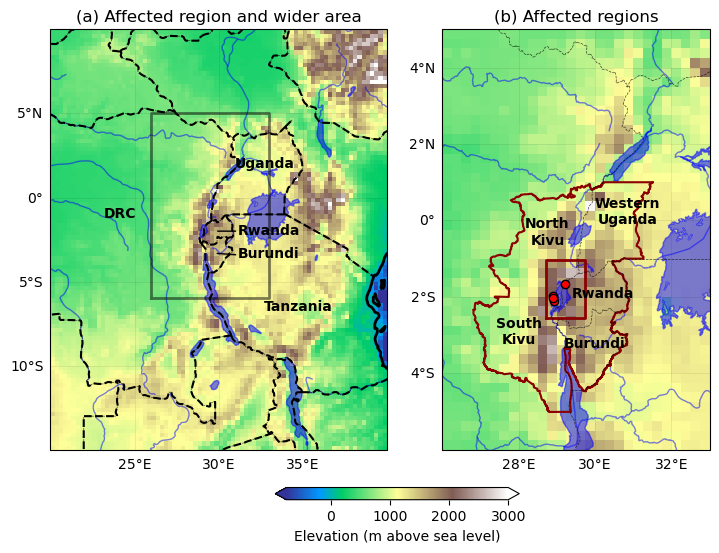

In [46]:
fig, axs = plt.subplots(ncols = 2, figsize = (9,7), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plt.subplots_adjust(wspace = 0.05)

elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
cbar = elev.plot(ax = ax, **elev_kwargs)

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left", "bottom"], alpha=0.1, xlocs = np.arange(20,40,5))
ax.set_title("(a) Affected region and wider area")

ax.plot([26,26,33,33,26], [-6,5,5,-6,-6], color = "k", lw = 2, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, lw = 1.5, ls = "--", zorder = 99)

[ax.annotate(k, xy = v, fontweight = "bold", textcoords="offset points", xytext=(2,-2), ha='left') for k, v in adm_labels.items()]
ax.plot([rw.geometry.centroid.x[0], adm_labels["Rwanda"][0]], [rw.geometry.centroid.y[0], adm_labels["Rwanda"][1]], color = "k", lw = 1)
ax.plot([bu.geometry.centroid.x[0], adm_labels["Burundi"][0]], [bu.geometry.centroid.y[0], adm_labels["Burundi"][1]], color = "k", lw = 1)

# pd.concat([rw, bu, ugw, drc.loc[["Sud-Kivu", "Nord-Kivu", "Ituri"]]]).explode(index_parts = True).dissolve().boundary.plot(ax = ax)

# rectangle(26,33,-6,5, ax = ax, color = "k", alpha = 0.1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
elev.sel(lon = slice(26,33), lat = slice(-6,5)).plot(ax = ax, **elev_kwargs)
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
ax.set_title("(b) Affected regions")

lk = get_latlon("Lake Kivu")
x0 = -0.5; x1 = 0.5; y0 = -0.5; y1 = 1
ax.plot([lk["lon"] + x_adj for x_adj in [x0,x0,x1,x1,x0]], [lk["lat"] + y_adj for y_adj in [y0,y1,y1,y0,y0]], color = "darkred", lw = 2)

sf.boundary.plot(ax = ax, color = "darkred")

[ax.scatter(*xy, marker = "o", color = "red", edgecolor = "k", zorder = 999) for xy in px.values()]

ax.annotate("South\nKivu", xy = (sk.geometry.centroid.x-0.25, sk.geometry.centroid.y), ha = "center", fontweight = "bold")
ax.annotate("Rwanda", xy = (rw.geometry.centroid.x+0.25, rw.geometry.centroid.y), ha = "center", fontweight = "bold")
ax.annotate("Western\nUganda", xy = (ugw.geometry.centroid.x+0.1, ugw.geometry.centroid.y-0.5), ha = "center", fontweight = "bold")

ax.annotate("North\nKivu", xy = (drc.loc["Nord-Kivu"].geometry.centroid.x+0.05, drc.loc["Nord-Kivu"].geometry.centroid.y), ha = "center", fontweight = "bold")
# ax.annotate("Ituri", xy = (drc.loc["Ituri"].geometry.centroid.x-0.25, drc.loc["Ituri"].geometry.centroid.y-0.25), ha = "center", fontweight = "bold")
ax.annotate("Burundi", xy = (bu.geometry.centroid.x+0.05, bu.geometry.centroid.y), ha = "center", fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:

    ax.coastlines(lw = 2)
    ax.add_feature(cartopy.feature.BORDERS, lw = 0.5, alpha = 0.7, ls = "--", zorder = 99)

    ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
    ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.5)
    
plt.colorbar(cbar, ax = axs, location = "bottom", extend = "both", shrink = 0.35, pad = 0.07, label = "Elevation (m above sea level)")

plt.savefig("fig/affected-regions.png")

### **Physical geography**

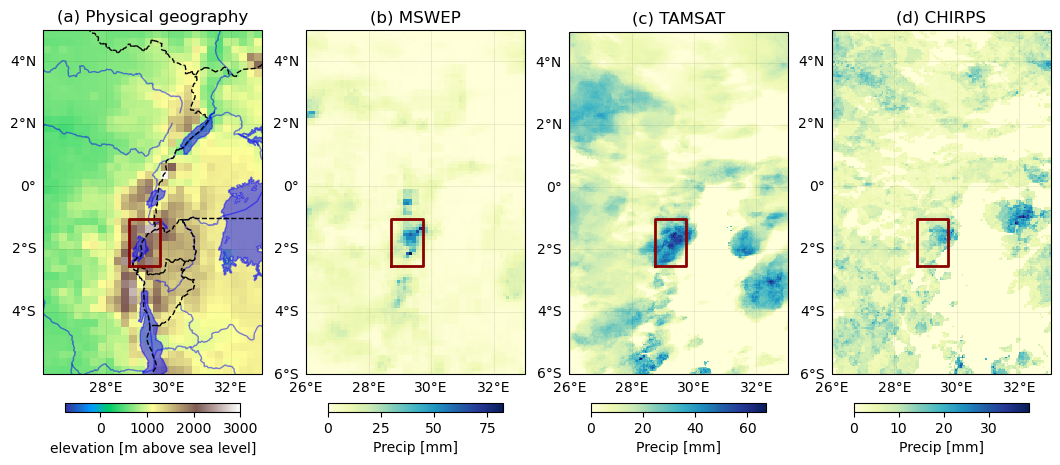

In [104]:
# small box centred on Lake Kivu
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(20,40), lat = slice(-15,10))
elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : True}
lk = get_latlon("Lake Kivu")

cbar_kwargs = {"location" : "bottom", "shrink" : 0.8, "fraction" : 0.025, "pad" : 0.075}

fig, axs = plt.subplots(ncols = 4, figsize = (13,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
elev.sel(lon = slice(26,33), lat = slice(-6,5)).plot(ax = axs[0], **elev_kwargs, cbar_kwargs = cbar_kwargs)
axs[0].set_title("(a) Physical geography")
axs[0].add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.5)
axs[0].add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
axs[0].add_feature(cartopy.feature.BORDERS, color = "k", ls = "--")
    
mswep.sel(time = "2023-05-02").plot(ax = axs[1], cmap = "YlGnBu", vmin = 0, add_colorbar = True, cbar_kwargs = cbar_kwargs | {"label" : "Precip [mm]"})
axs[1].set_title("(b) MSWEP")

tamsat.sel(time = "2023-05-02").plot(ax = axs[2], cmap = "YlGnBu", vmin = 0, add_colorbar = True, cbar_kwargs = cbar_kwargs | {"label" : "Precip [mm]"})
axs[2].set_title("(c) TAMSAT")

chirps.sel(time = "2023-05-02").plot(ax = axs[3], cmap = "YlGnBu", vmin = 0, add_colorbar = True, cbar_kwargs = cbar_kwargs | {"label" : "Precip [mm]"})
axs[3].set_title("(d) CHIRPS")


x0 = -0.5; x1 = 0.5; y0 = -0.5; y1 = 1

for ax in axs:

    ax.plot([lk["lon"] + x_adj for x_adj in [x0,x0,x1,x1,x0]], [lk["lat"] + y_adj for y_adj in [y0,y1,y1,y0,y0]], color = "darkred", lw = 2)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    
plt.savefig("fig/lake-kivu_region_1day.png")

### **May 2nd vs stations**

In [2]:
mswep = xr.open_mfdataset("data/mswep/mswep_daily_26_33_-6_5_*.nc").precip.sel(time = "2023-05-02").load()
cpc = xr.open_dataset("data/cpc_daily_26_33_-6_5.nc").precip.sel(time = "2023-05-02").load()
tamsat = xr.open_mfdataset("data/tamsat/*.nc").rfe_filled.sel(time = "2023-05-02").load()
chirps = xr.open_dataset("data/chirps_daily_26_33_-6_5.nc").precip.sel(time = "2023-05-02").load()
era5 = xr.open_dataset("data/era5_2023-daily_26_33_-6_5.nc").precip.sel(time = "2023-05-02").load()

stn = pd.read_csv("data/stations_north-western-rwanda.csv", index_col = 0)

lk = get_latlon("Lake Kivu")
x0 = -0.5; x1 = 0.5; y0 = -0.5; y1 = 1

lk_lon = slice(lk["lon"]+x0, lk["lon"]+x1)
lk_lat = slice(lk["lat"]+y0, lk["lat"]+y1)

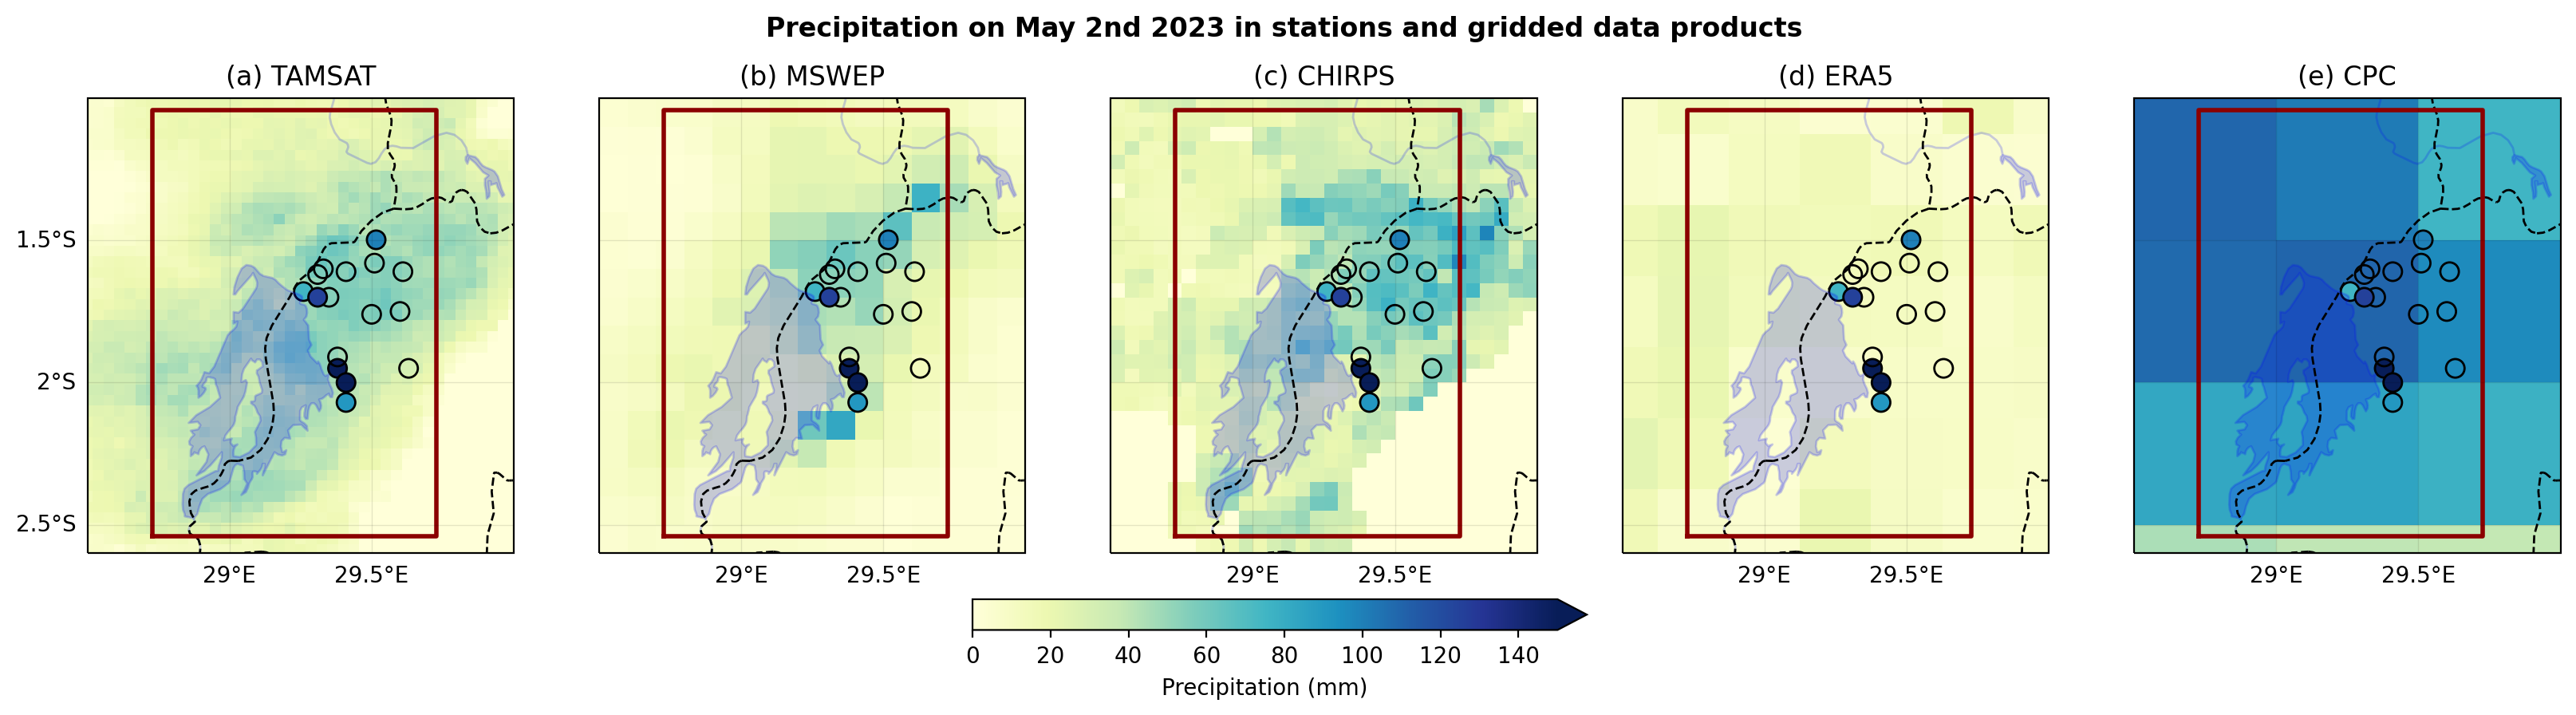

In [3]:
fig, axs = plt.subplots(ncols = 5, figsize = (20,5), dpi = 200, subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (28.5, 30, -2.6, -1)})

plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 150}

cbar = tamsat.plot(ax = axs[0], **plot_kwargs, add_colorbar = False); axs[0].set_title("(a) TAMSAT")
mswep.plot(ax = axs[1], **plot_kwargs, add_colorbar = False); axs[1].set_title("(b) MSWEP")
chirps.plot(ax = axs[2], **plot_kwargs, add_colorbar = False); axs[2].set_title("(c) CHIRPS")
era5.plot(ax = axs[3], **plot_kwargs, add_colorbar = False); axs[3].set_title("(d) ERA5")
cpc.plot(ax = axs[4], **plot_kwargs, add_colorbar = False); axs[4].set_title("(e) CPC")

for ax in axs: 
    ax.scatter(stn.loc["LON"], stn.loc["LAT"], c = stn.loc["20230502"], **plot_kwargs, ec = "k", s = 70)
    ax.scatter(*get_latlon("Shingiro, Rwanda").values(), c = 100, **plot_kwargs, ec = "k", s = 70) # also had its all-time maximum on May 2nd (100mm), but is in a different province
    ax.plot([lk["lon"] + x_adj for x_adj in [x0,x0,x1,x1,x0]], [lk["lat"] + y_adj for y_adj in [y0,y1,y1,y0,y0]], color = "darkred", lw = 2)
    
    ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.2)
    ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.2)
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--")
    
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = np.arange(28, 31, 0.5), ylocs = np.arange(-3,0,0.5))
    
axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0, xlocs = np.arange(28, 31, 0.5), ylocs = np.arange(-3,0,0.5))

plt.colorbar(cbar, ax = axs, label = "Precipitation (mm)", location = "bottom", fraction = 0.05, extend = "max", pad = 0.075)
plt.suptitle("Precipitation on May 2nd 2023 in stations and gridded data products", fontweight = "bold", y = 0.88)

plt.savefig("fig/station-vs-gridded_20230502.png")

### **rx5day over shapefile region**

In [4]:
mswep = xr.open_mfdataset("data/mswep/mswep_daily_26_33_-6_5_*.nc").precip.sel(time = slice("2023-05-01", "2023-05-05")).load().sum("time")
cpc = xr.open_dataset("data/cpc_daily_26_33_-6_5.nc").precip.sel(time = slice("2023-05-01", "2023-05-05")).load().sum("time")
tamsat = xr.open_mfdataset("data/tamsat/*.nc").rfe_filled.sel(time = slice("2023-05-01", "2023-05-05")).load().sum("time")
chirps = xr.open_dataset("data/chirps_daily_26_33_-6_5.nc").precip.sel(time = slice("2023-05-01", "2023-05-05")).load().sum("time")
era5 = xr.open_dataset("data/era5_2023-daily_26_33_-6_5.nc").precip.sel(time = slice("2023-05-01", "2023-05-05")).load().sum("time")

sf = gpd.read_file("sf_provisional/")

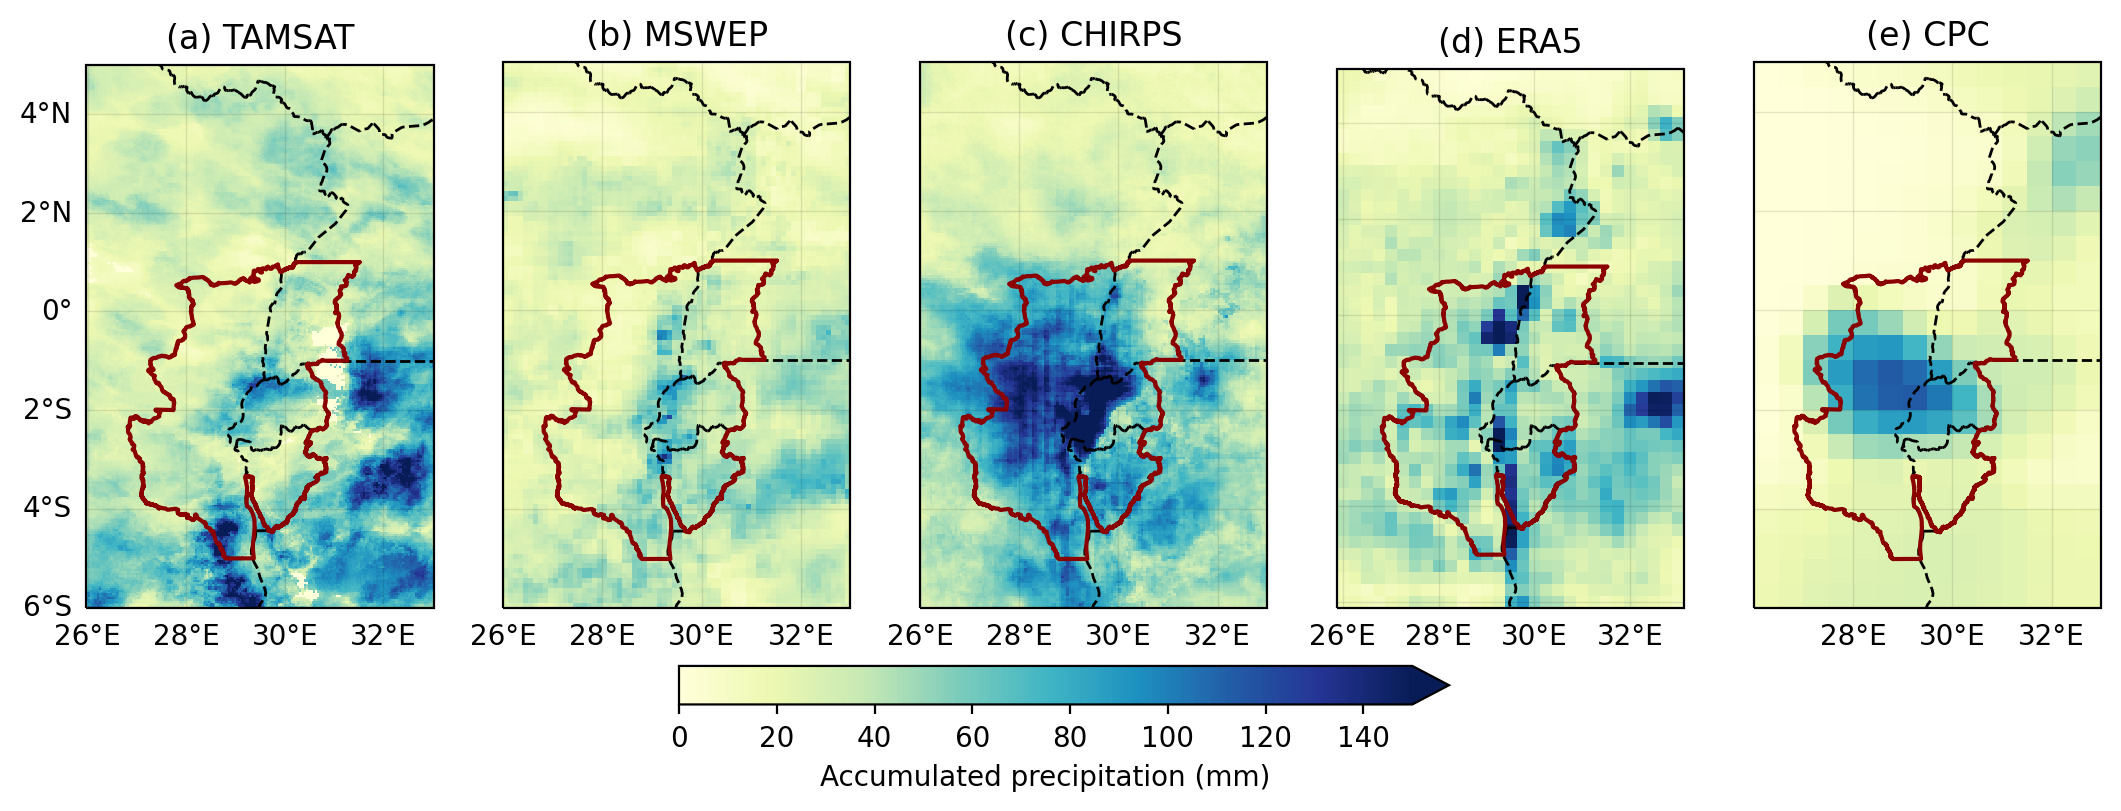

In [5]:
# small box centred on Lake Kivu
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(20,40), lat = slice(-15,10))
elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : True}
lk = get_latlon("Lake Kivu")

cbar_kwargs = {"location" : "bottom", "shrink" : 0.8, "fraction" : 0.025, "pad" : 0.075}
plot_kwargs = {"vmin" : 0, "vmax" : 150, "cmap" : "YlGnBu", "add_colorbar" : False}

fig, axs = plt.subplots(ncols = 5, figsize = (13,5), dpi = 200, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
# elev.sel(lon = slice(26,33), lat = slice(-6,5)).plot(ax = axs[0], **elev_kwargs, cbar_kwargs = cbar_kwargs | {"label" : "Elevation\n(m above sea level)"})
# axs[0].set_title("(a) Physical geography")
# axs[0].add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.5)
# axs[0].add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)

    
cbar = mswep.plot(ax = axs[1], **plot_kwargs)
axs[1].set_title("(b) MSWEP")

tamsat.plot(ax = axs[0], **plot_kwargs)
axs[0].set_title("(a) TAMSAT")

chirps.plot(ax = axs[2], **plot_kwargs)
axs[2].set_title("(c) CHIRPS")

era5.plot(ax = axs[3], **plot_kwargs)
axs[3].set_title("(d) ERA5")

cpc.plot(ax = axs[4], **plot_kwargs)
axs[4].set_title("(e) CPC")

x0 = -0.5; x1 = 0.5; y0 = -0.5; y1 = 1

for ax in axs:
    sf.boundary.plot(ax = ax, color = "darkred")
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--")
    # ax.plot([lk["lon"] + x_adj for x_adj in [x0,x0,x1,x1,x0]], [lk["lat"] + y_adj for y_adj in [y0,y1,y1,y0,y0]], color = "darkred", ls = "--",
    #         alpha = 0.8, lw = 1.5)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    
axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    
plt.colorbar(cbar, ax = axs, label = "Accumulated precipitation (mm)", location = "bottom", fraction = 0.05, extend = "max", pad = 0.075)
plt.savefig("fig/event-map_rx5day_shapefile-region.png")

## **Time series plots**

### **Daily precip over Lake Kivu, Apr-May 2023**

KeyError: "'time' is not a valid dimension or coordinate"

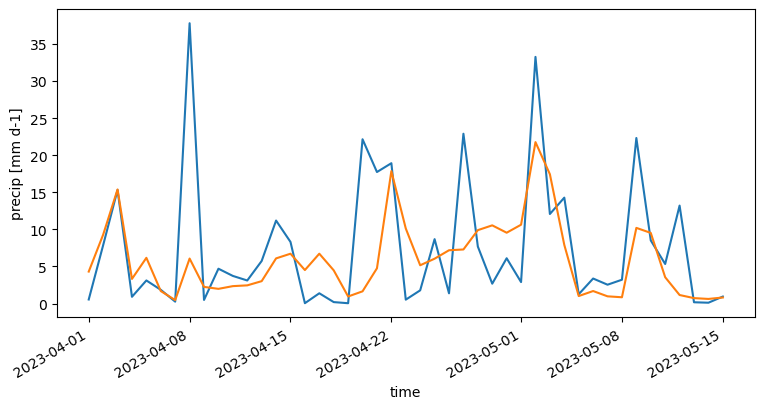

In [16]:
fig, ax = plt.subplots(ncols = 1, figsize = (9,4))

ds_list = ["tamsat", "mswep", "chirps", "era5", "cpc"]

for ds in ds_list:
        
    da = xr.open_dataset('daily/'+ds+'_daily_lake-kivu.nc').sel(time = "2023")
    da = da[list(da.data_vars)[0]]
    da.sel(time = slice("2023-04", "2023-05-15")).plot(ax = ax, label = ds)
    
    # da2 = xr.open_dataset('daily/'+ds+'_daily_shapefile.nc').sel(time = "2023")
    # da2 = da2[list(da2.data_vars)[0]]
    # da2.sel(time = slice("2023-04", "2023-05-15")).plot(ax = axs[1], label = ds)

# for ax in axs:
ax.set_ylabel("Precip (mm)")
ax.set_xlabel("")
ax.legend([ds.upper() for ds in ds_list])

# axs[0].set_title("(a) Daily precipitation over Lake Kivu region")
ax.add_patch(Rectangle((np.datetime64("2023-05-01"), -10), width = 2, height = 500, color = "gold", alpha = 0.5))

# axs[1].set_title("(b) 5-day accumulated precipitation over larger region")
# axs[1].add_patch(Rectangle((np.datetime64("2023-05-01"), -10), width = 4, height = 500, color = "gold", alpha = 0.5))

plt.savefig("fig/fig4_daily-precip-LakeKivu.png")

### **rx5day over DRC/Rwanda**

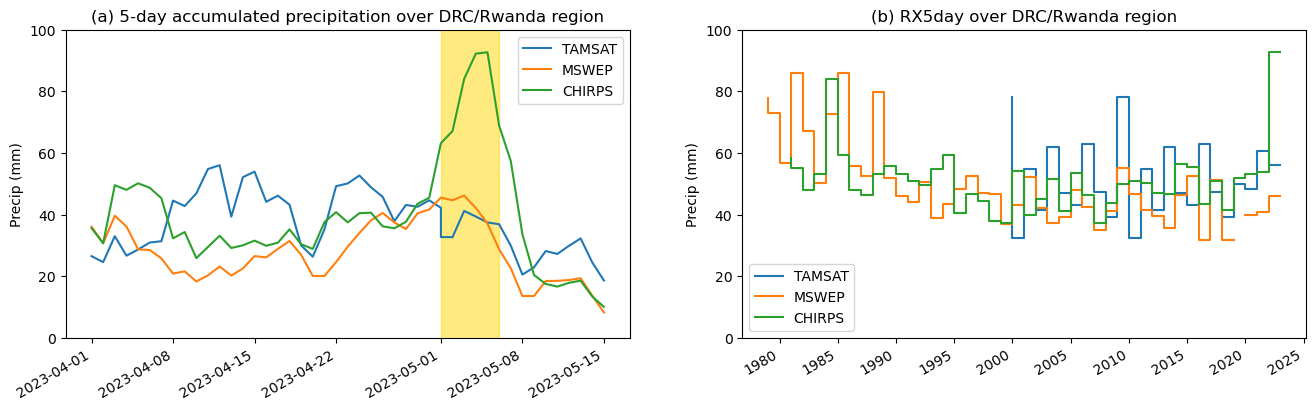

In [63]:
fig, axs = plt.subplots(ncols = 2, figsize = (16,4))

ds_list = ["tamsat", "mswep", "chirps"]

for ds in ds_list:
    
    da = xr.open_dataset('daily/'+ds+'_daily_shapefile.nc')
    da = da[list(da.data_vars)[0]].rolling(time = 5).sum()
    da.sel(time = slice("2023-04", "2023-05-15")).plot(ax = axs[0], label = ds)
    
    rx5day = da.sel(time = [m in [3,4,5] for m in da.time.dt.month]).resample(time = "AS-JAN").max().sel(time = slice("1979", None))
    rx5day.plot(ax = axs[1], drawstyle = "steps", label = ds)

for ax in axs:
    ax.set_ylabel("Precip (mm)")
    ax.set_xlabel("")
    ax.set_ylim(0,100)
    ax.legend([ds.upper() for ds in ds_list])

axs[0].set_title("(a) 5-day accumulated precipitation over DRC/Rwanda region")
axs[0].add_patch(Rectangle((np.datetime64("2023-05-01"), -10), width = 5, height = 500, color = "gold", alpha = 0.5))

axs[1].set_title("(b) RX5day over DRC/Rwanda region")

plt.savefig("fig/fig5_rx5day_drc-rwanda.png")

### **MAM over DRC/Rwanda**

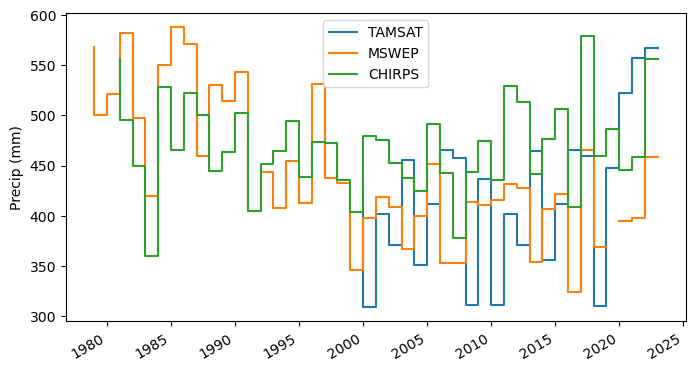

In [46]:
fig, ax = plt.subplots(ncols = 1, figsize = (8,4))

ds_list = ["tamsat", "mswep", "chirps"]

for ds in ds_list:
    
    da = xr.open_dataset('daily/'+ds+'_daily_shapefile.nc')
    da = da[list(da.data_vars)[0]]
#     da.sel(time = slice("2023-04", "2023-05-15")).plot(ax = axs[0], label = ds)
    
    rx5day = da.sel(time = [m in [3,4,5] for m in da.time.dt.month]).resample(time = "AS-JAN").sum()
    rx5day.plot(ax = ax, drawstyle = "steps", label = ds)

for ax in [ax]:
    ax.set_ylabel("Precip (mm)")
    ax.set_xlabel("")
    ax.legend([ds.upper() for ds in ds_list])

plt.savefig("fig/fig5_mam_drc-rwanda.png")

## **Validation against station data**

### **MAM 2021 vs stations**

In [47]:
mswep = xr.open_mfdataset("data/mswep/mswep_daily_26_33_-6_5_*.nc").precip.sel(time = slice("2021-03", "2021-05")).load()
cpc = xr.open_dataset("data/cpc_daily_26_33_-6_5.nc").precip.sel(time = slice("2021-03", "2021-05")).load()
tamsat = xr.open_mfdataset("data/tamsat/*.nc").rfe_filled.sel(time = slice("2021-03", "2021-05")).load()
chirps = xr.open_dataset("data/chirps_daily_26_33_-6_5.nc").precip.sel(time = slice("2021-03", "2021-05")).load()
era5 = xr.open_dataset("data/era5_2023-daily_26_33_-6_5.nc").precip.sel(time = slice("2021-03", "2021-05")).load()

In [48]:
stn = pd.read_csv("data/stations_north-western-rwanda.csv", index_col = 0)
stn_loc = stn[:2]
stn = stn[2:]
stn.index = [datetime(int(d[:4]), int(d[4:6]), int(d[6:])) for d in stn.index]
stn = stn.loc[slice("2021-03", "2021-05")]

In [49]:
for ds in ["MSWEP", "CPC", "CHIRPS", "TAMSAT", "ERA5"]:

    fig, axs = plt.subplots(ncols = 5, nrows = 3, figsize = (20,12), dpi = 100)
    plt.subplots_adjust(hspace = 0.3)

    for i in range(len(stn.columns)):

        ax = fig.axes[i]
        stn_name = stn.columns[i]

        stn[stn_name].dropna(axis = 0, how = "any").plot(ax = ax, color = "k")
        nearest_px(*stn_loc[stn_name], eval(ds.lower()), xcoord = "lon", ycoord = "lat").plot(ax = ax, label = ds)

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title(stn_name)
        
    for i in range(len(stn.columns), len(fig.axes)): fig.axes[i].set_axis_off()
    
    plt.suptitle("Validation of "+ds+" (blue) vs station data (black): MAM 2021", fontweight = "bold", y = 0.925)
    plt.savefig("fig/station-validation-mam21_"+ds+".png"); plt.close()

### **rx5day-mam vs stations**

In [50]:
mswep = xr.open_mfdataset("data/mswep/mswep_daily_26_33_-6_5_*.nc").precip.load()
cpc = xr.open_dataset("data/cpc_daily_26_33_-6_5.nc").precip.load()
tamsat = xr.open_mfdataset("data/tamsat/*.nc").rfe_filled.load()
chirps = xr.open_dataset("data/chirps_daily_26_33_-6_5.nc").precip.load()
era5 = xr.open_dataset("data/era5_2023-daily_26_33_-6_5.nc").precip.load()

In [51]:
mswep, cpc, tamsat, chirps, era5 = [ds.rolling(time = 5).sum().sel(time = [m in [3,4,5] for m in ds.time.dt.month]).resample(time = "AS-JAN").max() for ds in [mswep, cpc, tamsat, chirps, era5]]

In [52]:
stn = pd.read_csv("data/stations_north-western-rwanda.csv", index_col = 0)
stn_loc = stn[:2]
stn = stn[2:]
stn.index = [datetime(int(d[:4]), int(d[4:6]), int(d[6:])) for d in stn.index]

stn_rx5day = stn.rolling(5).sum().loc[[m in [3,4,5] for m in stn.index.month]].resample("AS-JAN").max()
stn_rx5day.index = stn_rx5day.index.year

In [53]:
for ds in ["MSWEP", "CPC", "CHIRPS", "TAMSAT", "ERA5"]:

    fig, axs = plt.subplots(ncols = 5, nrows = 3, figsize = (20,12), dpi = 100)
    plt.subplots_adjust(hspace = 0.3)

    for i in range(len(stn.columns)):

        ax = fig.axes[i]
        stn_name = stn.columns[i]
        stn_i = stn_rx5day[stn_name]
        stn_i[stn_i <= 0] = np.nan
        
        stn_i.plot(ax = ax, color = "k", drawstyle = "steps")
        
        ts_gridded = nearest_px(*stn_loc[stn_name], eval(ds.lower()), xcoord = "lon", ycoord = "lat")
        ts_gridded.assign_coords(time = ts_gridded.time.dt.year).plot(ax = ax, label = ds, drawstyle = "steps")

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title(stn_name)
        
    for i in range(len(stn.columns), len(fig.axes)): fig.axes[i].set_axis_off()
    
    plt.suptitle("Validation of "+ds+" (blue) vs station data (black): RX5day-MAM", fontweight = "bold", y = 0.925)
    plt.savefig("fig/station-validation-rx5day-mam_"+ds+".png"); plt.close()

### **mam vs stations**

In [54]:
mswep = xr.open_mfdataset("data/mswep/mswep_daily_26_33_-6_5_*.nc").precip.load()
cpc = xr.open_dataset("data/cpc_daily_26_33_-6_5.nc").precip.load()
tamsat = xr.open_mfdataset("data/tamsat/*.nc").rfe_filled.load()
chirps = xr.open_dataset("data/chirps_daily_26_33_-6_5.nc").precip.load()
era5 = xr.open_dataset("data/era5_2023-daily_26_33_-6_5.nc").precip.load()

In [55]:
mswep, cpc, tamsat, chirps, era5 = [ds.sel(time = [m in [3,4,5] for m in ds.time.dt.month]).resample(time = "AS-JAN").sum() for ds in [mswep, cpc, tamsat, chirps, era5]]

In [56]:
stn = pd.read_csv("data/stations_north-western-rwanda.csv", index_col = 0)
stn_loc = stn[:2]
stn = stn[2:]
stn.index = [datetime(int(d[:4]), int(d[4:6]), int(d[6:])) for d in stn.index]

stn_mam = stn.loc[[m in [3,4,5] for m in stn.index.month]].resample("AS-JAN").sum()
stn_mam.index = stn_mam.index.year

In [57]:
for ds in ["MSWEP", "CPC", "CHIRPS", "TAMSAT", "ERA5"]:

    fig, axs = plt.subplots(ncols = 5, nrows = 3, figsize = (20,12), dpi = 100)
    plt.subplots_adjust(hspace = 0.3)

    for i in range(len(stn.columns)):

        ax = fig.axes[i]
        stn_name = stn.columns[i]
        stn_i = stn_mam[stn_name]
        stn_i[stn_i <= 0] = np.nan
        
        stn_i.plot(ax = ax, color = "k", drawstyle = "steps")
        
        ts_gridded = nearest_px(*stn_loc[stn_name], eval(ds.lower()), xcoord = "lon", ycoord = "lat")
        ts_gridded.assign_coords(time = ts_gridded.time.dt.year).plot(ax = ax, label = ds, drawstyle = "steps")

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title(stn_name)
        
    for i in range(len(stn.columns), len(fig.axes)): fig.axes[i].set_axis_off()
    
    plt.suptitle("Validation of "+ds+" (blue) vs station data (black): MAM accumulated precip", fontweight = "bold", y = 0.925)
    plt.savefig("fig/station-validation-mam_"+ds+".png"); plt.close()

# **Plots for webpage**

## **RX1day on May 2nd with stations**

In [3]:
mswep = xr.open_mfdataset("data/mswep/mswep_daily_26_33_-6_5_*.nc").precip.sel(time = "2023-05-02").load()
cpc = xr.open_dataset("data/cpc_daily_26_33_-6_5.nc").precip.sel(time = "2023-05-02").load()
tamsat = xr.open_mfdataset("data/tamsat/*.nc").rfe_filled.sel(time = "2023-05-02").load()
chirps = xr.open_dataset("data/chirps_daily_26_33_-6_5.nc").precip.sel(time = "2023-05-02").load()
era5 = xr.open_dataset("data/era5_2023-daily_26_33_-6_5.nc").precip.sel(time = "2023-05-02").load()

stn = pd.read_csv("data/stations_north-western-rwanda.csv", index_col = 0)

lk = get_latlon("Lake Kivu")
x0 = -0.5; x1 = 0.5; y0 = -0.5; y1 = 1

lk_lon = slice(lk["lon"]+x0, lk["lon"]+x1)
lk_lat = slice(lk["lat"]+y0, lk["lat"]+y1)

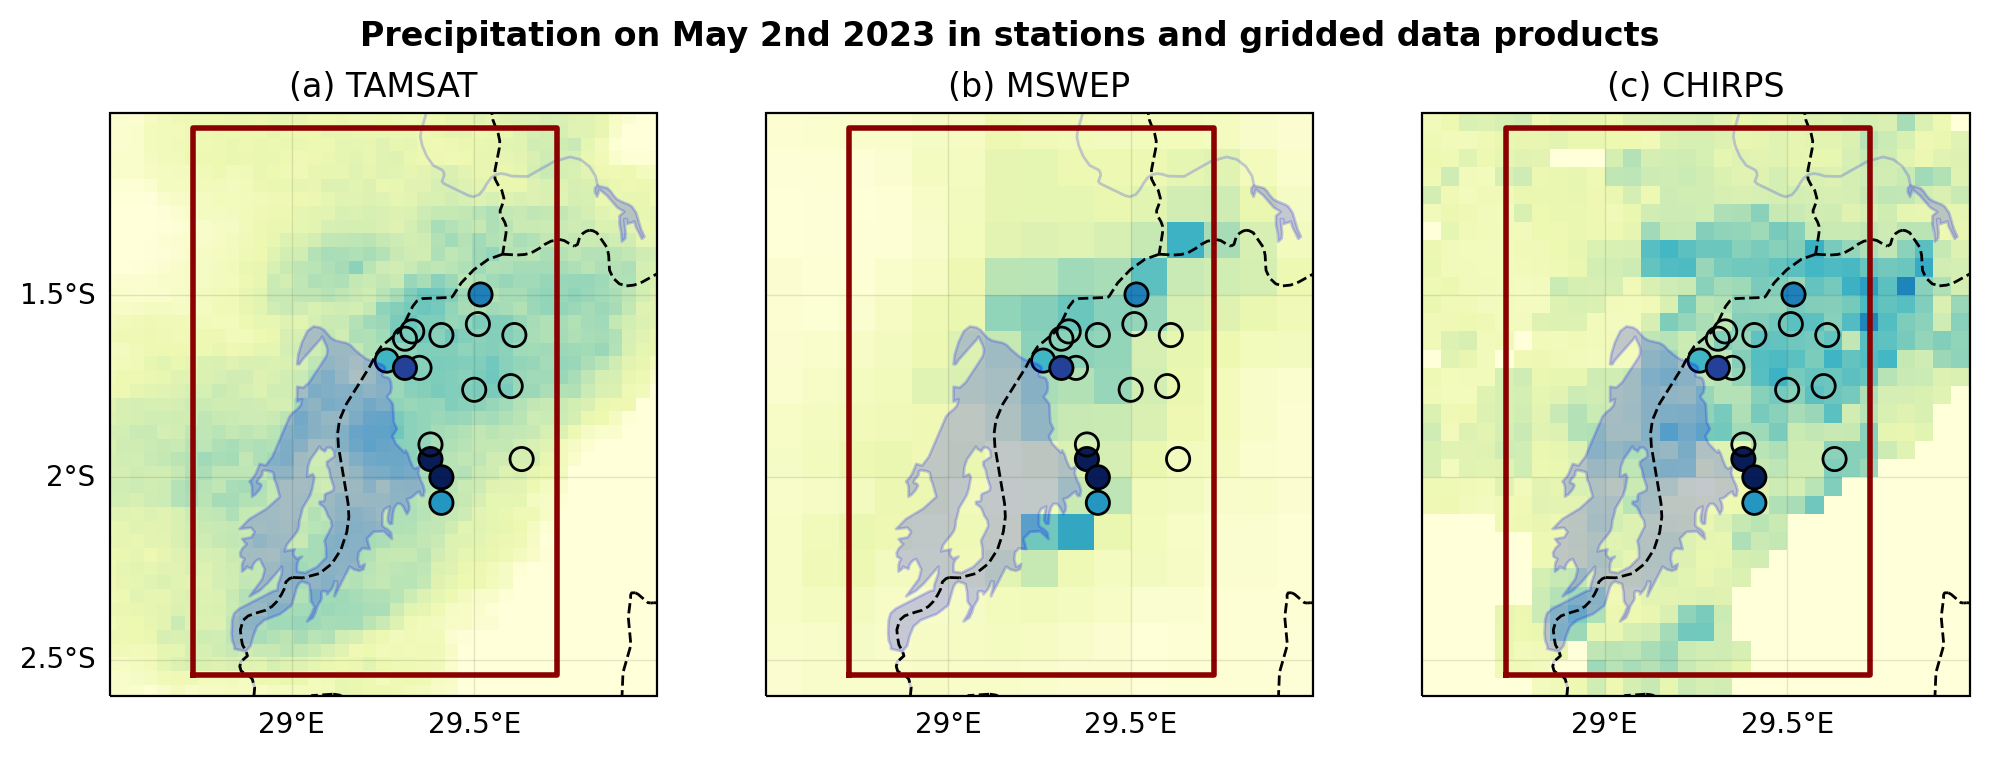

In [5]:
fig, axs = plt.subplots(ncols = 3, figsize = (12,5), dpi = 200, subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (28.5, 30, -2.6, -1)})

plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 150}

cbar = tamsat.plot(ax = axs[0], **plot_kwargs, add_colorbar = False); axs[0].set_title("(a) TAMSAT")
mswep.plot(ax = axs[1], **plot_kwargs, add_colorbar = False); axs[1].set_title("(b) MSWEP")
chirps.plot(ax = axs[2], **plot_kwargs, add_colorbar = False); axs[2].set_title("(c) CHIRPS")
# era5.plot(ax = axs[3], **plot_kwargs, add_colorbar = False); axs[3].set_title("(d) ERA5")
# cpc.plot(ax = axs[4], **plot_kwargs, add_colorbar = False); axs[4].set_title("(e) CPC")

for ax in axs: 
    ax.scatter(stn.loc["LON"], stn.loc["LAT"], c = stn.loc["20230502"], **plot_kwargs, ec = "k", s = 70)
    ax.scatter(*get_latlon("Shingiro, Rwanda").values(), c = 100, **plot_kwargs, ec = "k", s = 70) # also had its all-time maximum on May 2nd (100mm), but is in a different province
    ax.plot([lk["lon"] + x_adj for x_adj in [x0,x0,x1,x1,x0]], [lk["lat"] + y_adj for y_adj in [y0,y1,y1,y0,y0]], color = "darkred", lw = 2)
    
    ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.2)
    ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.2)
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--")
    
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = np.arange(28, 31, 0.5), ylocs = np.arange(-3,0,0.5))
    
axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0, xlocs = np.arange(28, 31, 0.5), ylocs = np.arange(-3,0,0.5))

# plt.colorbar(cbar, ax = axs, label = "Precipitation (mm)", location = "bottom", fraction = 0.05, extend = "max", pad = 0.075)
plt.suptitle("Precipitation on May 2nd 2023 in stations and gridded data products", fontweight = "bold", y = 0.88)

plt.savefig("fig/web_rx1day-20230502-1.png")

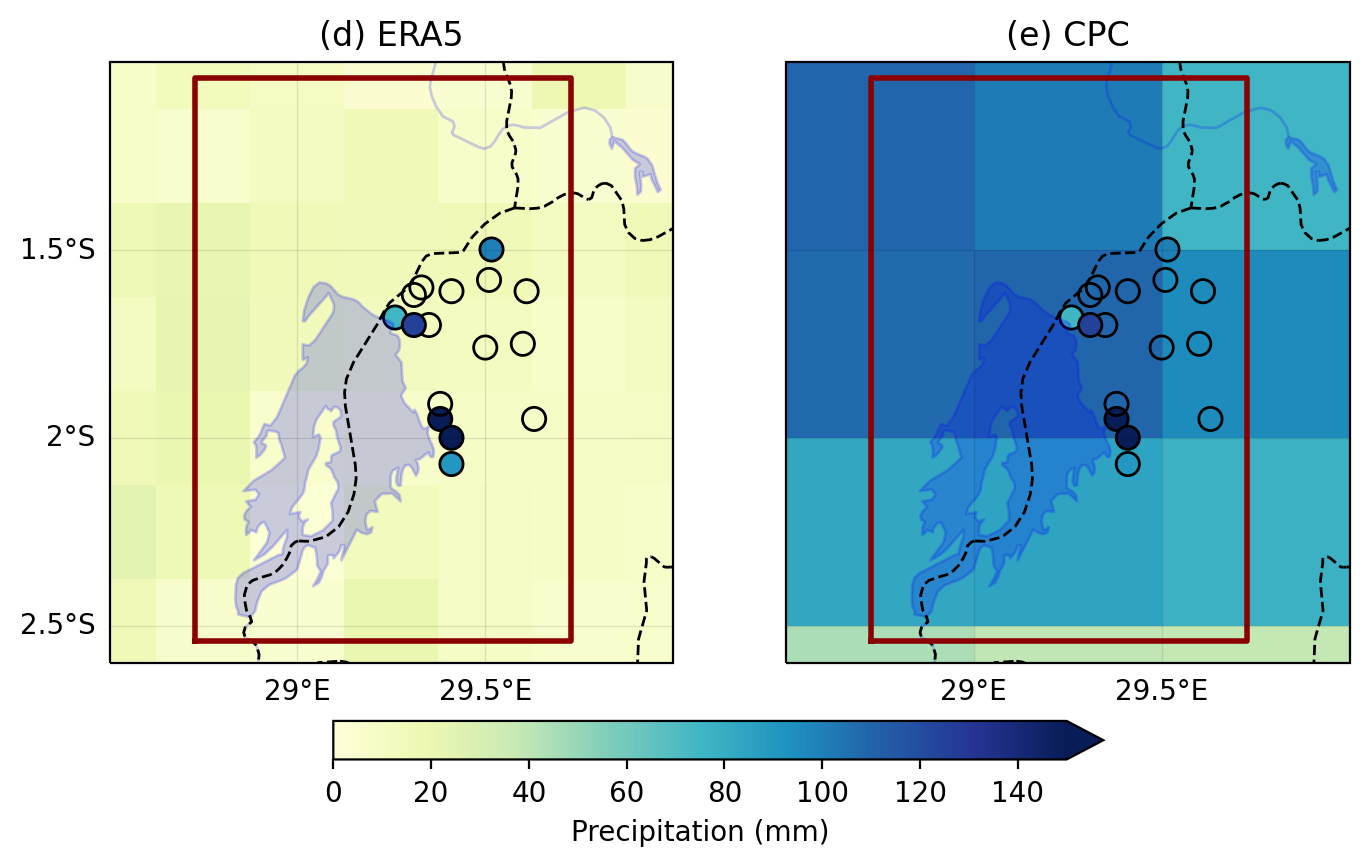

In [8]:
fig, axs = plt.subplots(ncols = 2, figsize = (8,5), dpi = 200, subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (28.5, 30, -2.6, -1)})

plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 150}

# cbar = tamsat.plot(ax = axs[0], **plot_kwargs, add_colorbar = False); axs[0].set_title("(a) TAMSAT")
# mswep.plot(ax = axs[1], **plot_kwargs, add_colorbar = False); axs[1].set_title("(b) MSWEP")
# chirps.plot(ax = axs[2], **plot_kwargs, add_colorbar = False); axs[2].set_title("(c) CHIRPS")
era5.plot(ax = axs[0], **plot_kwargs, add_colorbar = False); axs[0].set_title("(d) ERA5")
cpc.plot(ax = axs[1], **plot_kwargs, add_colorbar = False); axs[1].set_title("(e) CPC")

for ax in axs: 
    ax.scatter(stn.loc["LON"], stn.loc["LAT"], c = stn.loc["20230502"], **plot_kwargs, ec = "k", s = 70)
    ax.scatter(*get_latlon("Shingiro, Rwanda").values(), c = 100, **plot_kwargs, ec = "k", s = 70) # also had its all-time maximum on May 2nd (100mm), but is in a different province
    ax.plot([lk["lon"] + x_adj for x_adj in [x0,x0,x1,x1,x0]], [lk["lat"] + y_adj for y_adj in [y0,y1,y1,y0,y0]], color = "darkred", lw = 2)
    
    ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.2)
    ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.2)
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--")
    
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = np.arange(28, 31, 0.5), ylocs = np.arange(-3,0,0.5))
    
axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0, xlocs = np.arange(28, 31, 0.5), ylocs = np.arange(-3,0,0.5))

plt.colorbar(cbar, ax = axs, label = "Precipitation (mm)", location = "bottom", fraction = 0.05, extend = "max", pad = 0.075)
# plt.suptitle("Precipitation on May 2nd 2023 in stations and gridded data products", fontweight = "bold", y = 0.88)

plt.savefig("fig/web_rx1day-20230502-2.png")

### **RX5day on May 5th**

In [9]:
mswep = xr.open_mfdataset("data/mswep/mswep_daily_26_33_-6_5_*.nc").precip.sel(time = slice("2023-05-01", "2023-05-05")).load().sum("time")
cpc = xr.open_dataset("data/cpc_daily_26_33_-6_5.nc").precip.sel(time = slice("2023-05-01", "2023-05-05")).load().sum("time")
tamsat = xr.open_mfdataset("data/tamsat/*.nc").rfe_filled.sel(time = slice("2023-05-01", "2023-05-05")).load().sum("time")
chirps = xr.open_dataset("data/chirps_daily_26_33_-6_5.nc").precip.sel(time = slice("2023-05-01", "2023-05-05")).load().sum("time")
era5 = xr.open_dataset("data/era5_2023-daily_26_33_-6_5.nc").precip.sel(time = slice("2023-05-01", "2023-05-05")).load().sum("time")

sf = gpd.read_file("sf_provisional/")

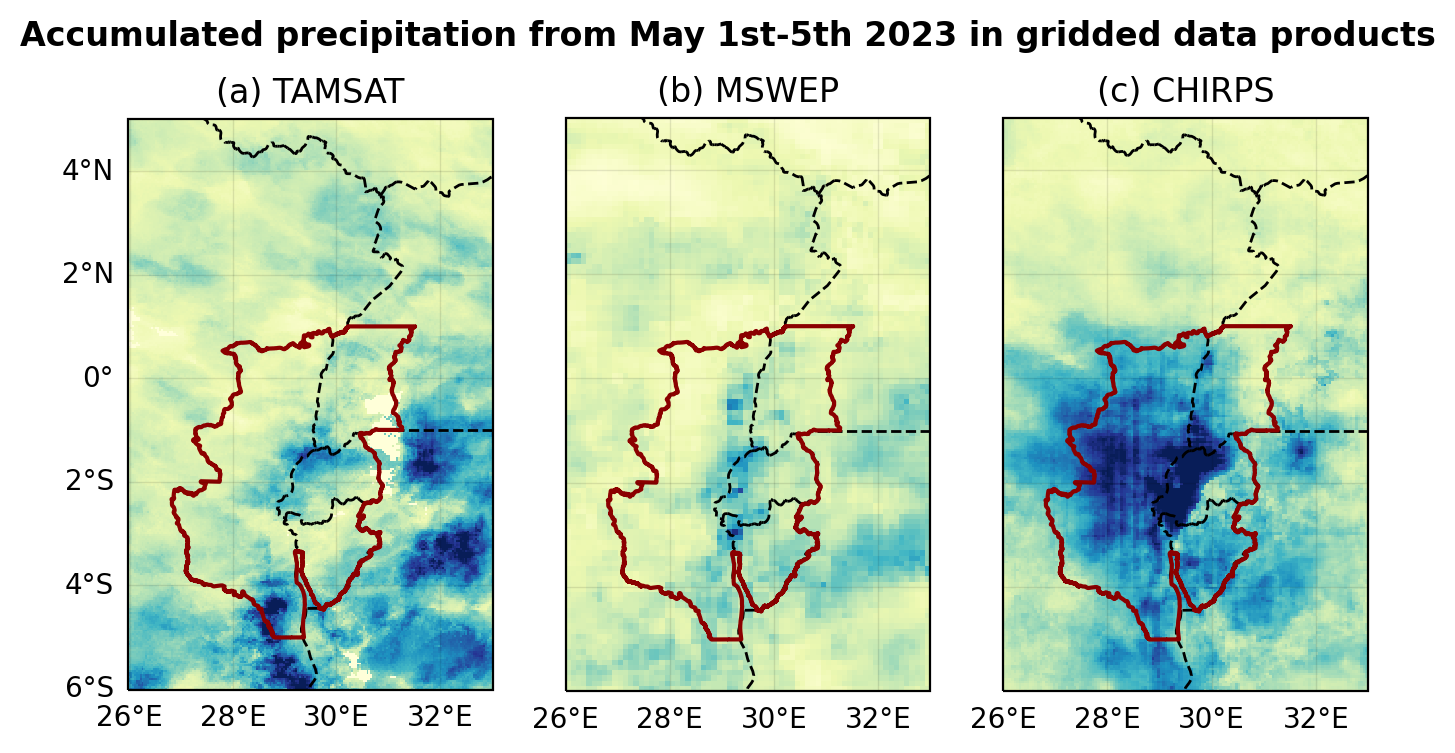

In [19]:
# small box centred on Lake Kivu
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(20,40), lat = slice(-15,10))
elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : True}
lk = get_latlon("Lake Kivu")

cbar_kwargs = {"location" : "bottom", "shrink" : 0.8, "fraction" : 0.025, "pad" : 0.075}
plot_kwargs = {"vmin" : 0, "vmax" : 150, "cmap" : "YlGnBu", "add_colorbar" : False}

fig, axs = plt.subplots(ncols = 3, figsize = (8,5), dpi = 200, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
    
cbar = mswep.plot(ax = axs[1], **plot_kwargs)
axs[1].set_title("(b) MSWEP")

tamsat.plot(ax = axs[0], **plot_kwargs)
axs[0].set_title("(a) TAMSAT")

chirps.plot(ax = axs[2], **plot_kwargs)
axs[2].set_title("(c) CHIRPS")

# era5.plot(ax = axs[3], **plot_kwargs)
# axs[3].set_title("(d) ERA5")

# cpc.plot(ax = axs[4], **plot_kwargs)
# axs[4].set_title("(e) CPC")

x0 = -0.5; x1 = 0.5; y0 = -0.5; y1 = 1

for ax in axs:
    sf.boundary.plot(ax = ax, color = "darkred")
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--")
    # ax.plot([lk["lon"] + x_adj for x_adj in [x0,x0,x1,x1,x0]], [lk["lat"] + y_adj for y_adj in [y0,y1,y1,y0,y0]], color = "darkred", ls = "--",
    #         alpha = 0.8, lw = 1.5)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    
axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    
# plt.colorbar(cbar, ax = axs, label = "Accumulated precipitation (mm)", location = "bottom", fraction = 0.05, extend = "max", pad = 0.075)
plt.suptitle("Accumulated precipitation from May 1st-5th 2023 in gridded data products", fontweight = "bold", y = 0.88)

plt.savefig("fig/web_rx5day-20230505-1.png")

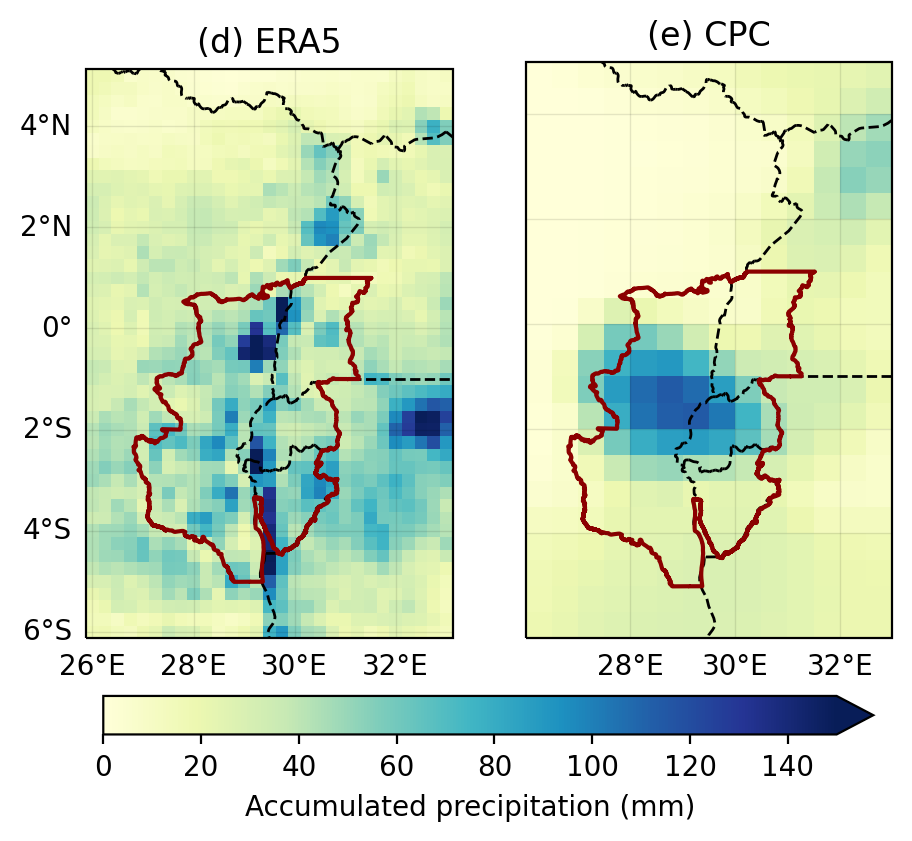

In [18]:
# small box centred on Lake Kivu
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(20,40), lat = slice(-15,10))
elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : True}
lk = get_latlon("Lake Kivu")

cbar_kwargs = {"location" : "bottom", "shrink" : 0.8, "fraction" : 0.025, "pad" : 0.075}
plot_kwargs = {"vmin" : 0, "vmax" : 150, "cmap" : "YlGnBu", "add_colorbar" : False}

fig, axs = plt.subplots(ncols = 2, figsize = (5.2,5), dpi = 200, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
    
# cbar = mswep.plot(ax = axs[1], **plot_kwargs)
# axs[1].set_title("(b) MSWEP")

# tamsat.plot(ax = axs[0], **plot_kwargs)
# axs[0].set_title("(a) TAMSAT")

# chirps.plot(ax = axs[2], **plot_kwargs)
# axs[2].set_title("(c) CHIRPS")

era5.plot(ax = axs[0], **plot_kwargs)
axs[0].set_title("(d) ERA5")

cpc.plot(ax = axs[1], **plot_kwargs)
axs[1].set_title("(e) CPC")

x0 = -0.5; x1 = 0.5; y0 = -0.5; y1 = 1

for ax in axs:
    sf.boundary.plot(ax = ax, color = "darkred")
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--")
    # ax.plot([lk["lon"] + x_adj for x_adj in [x0,x0,x1,x1,x0]], [lk["lat"] + y_adj for y_adj in [y0,y1,y1,y0,y0]], color = "darkred", ls = "--",
    #         alpha = 0.8, lw = 1.5)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    
axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    
plt.colorbar(cbar, ax = axs, label = "Accumulated precipitation (mm)", location = "bottom", fraction = 0.05, extend = "max", pad = 0.075)
plt.savefig("fig/web_rx5day-20230505-2.png")